# General Backtester for Panoptions 
On:
- Any Uni V3 Pool
- Any Time Period
- Any Range Factor
- Any # of put & call legs
- Any delta for each leg
- Includes Subsample Testing
- Support for custom Base data
- Added yearly rolling (previously had daily, weekly, and monthly)

### Import Python Packages

In [2]:
import pandas as pd
import pandas_gbq
import pydata_google_auth
import numpy as np
import matplotlib.pyplot as plt
import math
import calendar
from tqdm import tqdm
from datetime import timedelta
from functools import reduce
from scipy.stats import skew

pd.options.mode.chained_assignment = None

In [3]:
plt.style.use('/Users/amyoumaymakhaldoun/Desktop/Codes_business/Panoptic/panoptic-dark-16_9.mplstyle')

# Parse Data 

In [16]:
class LP_Rebalance:
    def __init__(
        self,
        token_0: str,
        token_1: str,
        fee: int, # in bps
        local_dir: str,
        start_t: str,
        end_t: str,
        range_perc: float, # i.e. +/- 30%
        col_ratio: float=100, # i.e. 100%
        com_ratio: float=0, # i.e. 0bps
        PLP_annual_yield: float=0, # i.e. 0%
        spread_mult: float=1,
        pool_data: pd.DataFrame=None,
        inverse_price: bool=True,
        legs: list=[('short_put', 1, 0.5)], # option_type, option_ratio, delta
        chain: str='Ethereum',
    ) -> None:
        """
        Initialize LP Rebalancing class
        
        :token_0 Token 0
        :token_1 Token 1
        :fee fee rate in bps
        :local_dir local directory to save plots
        :start_t start time (inclusive) (i.e. '2021-05-06 00:06:12' or '2021-05-06')
        :end_t end time (exclusive)
        :range_perc range percent (for +/- 30%, input 30)
        :col_ratio collateral ratio (%) - assumes position is never underwater or liquidated
        :com_ratio commission ratio (bps)
        :PLP_annual_yield annual yield from providing Panoptic liquidity (%)
        :spread_mult spread multiplier for buying popular options
        :pool_data enter dataframe of pool data from another strategy to save load time. Default=None
        :inverse_price invert the price (if true: gets price of token_1 in terms of token_0)
        :legs type of option ['SHORT_PUT', 'LONG_PUT', 'SHORT_CALL', 'LONG_CALL'], option_ratio, and delta
        :chain Ethereum (default) or Base (need special data)
        """
        self.token_0 = token_0
        self.token_1 = token_1
        self.fee_rate = fee / 10_000
        self.pool_address = LP_Rebalance.get_pool_address(self.token_0, self.token_1, fee, chain)
        self.dec_0 = LP_Rebalance.get_token_dec(self.token_0)
        self.dec_1 = LP_Rebalance.get_token_dec(self.token_1)
        self.tick_spacing = LP_Rebalance.get_tick_spacing(fee)
        ''' Our_capital is 1 b/c it allows results to be interpreted as percentages
        Strategy does accounting in numeraire token
        I.e. start with 1 token of numeraire, split 50/50 to LP.
        At end of rebalancing period (e.g. 1 day), we sell everything back into the numeraire token
        And calculate the % change (return) on the numeraire token '''
        self.our_capital = 1 # in token y
        self.raw_dir = local_dir
        self.start_t = start_t
        self.end_t = end_t
        self.range_perc = (range_perc / 100) + 1
        self.tick_width = LP_Rebalance.convert_r_to_tick_width(self.range_perc)
        self.col_ratio = col_ratio / 100
        self.com_ratio = com_ratio / 10_000
        self.collateral = self.our_capital * self.col_ratio
        self.PLP_annual_yield = PLP_annual_yield / 100
        self.spread_mult = spread_mult
        ''' If inverse_price, our numeraire is token_0
        Else, our numeraire is token_1
        Ex: For USDC/ETH pool:
        token 0 = USDC
        token 1 = ETH
        Inverse_price = True -> we calculate returns in terms of USDC
        Inverse_price = False -> we calculate returns in terms of ETH
        This will affect results! '''
        self.inverse_price = inverse_price

        valid_options = ['SHORT_PUT', 'LONG_PUT', 'SHORT_CALL', 'LONG_CALL']
        for leg, _, _ in legs:
            if leg not in valid_options:
                raise BaseException(f"Invalid option type. Valid types: {valid_options}")
        self.legs = legs

        self.BASE = 1.0001

        if pool_data is None:
            self.load_pool_data()
        else:
            self.data = pool_data
            if 'date' not in self.data.columns: # data loaded in from other blockchains like Base
                self.data = self.data[
                    (self.data["block_timestamp"] >= self.start_t) & 
                    (self.data["block_timestamp"] <= self.end_t) &
                    (self.data["address"] == self.pool_address)
                ]
                self.transform_pool_data(indexSupply=True)

        

    def load_pool_data(self):
        """Loads Univ3 pool swap data"""
        # Replace this function with your own GBQ data fetcher
        # See: https://github.com/panoptic-labs/research/blob/JP/_research-bites/DataTutorial/tutorial.ipynb
        print("Loading Data...")

        SCOPES = [
            'https://www.googleapis.com/auth/cloud-platform',
            'https://www.googleapis.com/auth/drive',
        ]

        credentials = pydata_google_auth.get_user_credentials(
            SCOPES,
            auth_local_webserver=True,
        )

        query = f"""
        SELECT DISTINCT *
        FROM `arcane-world-371019.First_sync.1`
        WHERE address = '{self.pool_address}'
            AND block_timestamp >= '{self.start_t}'
            AND block_timestamp < '{self.end_t}'
        ORDER BY block_number, transaction_index
        """
        self.data = pandas_gbq.read_gbq(query, project_id = "arcane-world-371019", credentials=credentials)
        self.transform_pool_data()

    def transform_pool_data(self, indexSupply=False):
        if not indexSupply:
            """Transform amounts to human-readable format"""
            self.data['amount0'] = self.data['amount0'].apply(LP_Rebalance.get_twos_comp)
            self.data['amount1'] = self.data['amount1'].apply(LP_Rebalance.get_twos_comp)

            # Unpack sqrt price
            self.data['sqrtPrice'] = self.data['sqrtPrice'].apply(LP_Rebalance.unpack_sqrtprice)

        else:
            self.data['sqrtPrice'] = self.data['sqrtPrice'].astype(str).astype(float).apply(
                lambda x: LP_Rebalance.unpack_sqrtprice(x, is_hex=False)
            )
        
        self.data['amount0'] = self.data['amount0'].astype(float) / (10 ** self.dec_0)
        self.data['amount1'] = self.data['amount1'].astype(float) / (10 ** self.dec_1)

        self.data['price'] = self.data['tick'].apply(self.convert_tick)

        # Note our GBQ query ordered by blocknumber, transaciton_index
        self.data.set_index('block_timestamp', inplace=True) # Assume block timestamps are accurate "enough" for our use-case
        self.data.index = pd.to_datetime(self.data.index)

        # Calculate sqrt price change
        self.data = LP_Rebalance.calc_sqrtprice_change(self.data)

        self.data['date'] = self.data.index.date
        # Lag prices (Have to do for illiquid pools w/few txs per day)
        self.data['price_lag'] = self.data['price'].shift()
        self.data['tick_lag'] = self.data['tick'].shift()
        self.data['sqrtPrice_lag'] = self.data['sqrtPrice'].shift()
        self.data = self.data.iloc[1:]

    def run_strat(self, rolling_frequency: str='a'):
        print("Running Strategy")
        self.create_strat(rolling_frequency=rolling_frequency)
        quantity_total = sum(leg[1] for leg in self.legs)

        if rolling_frequency == 'a' or rolling_frequency == 'd':
            tqdm().pandas(desc='Step 1') # Calculate liquidity per tick
            self.daily['liq_per_tick'] = self.daily.progress_apply(self.calc_liq_per_tick, axis=1)        
            tqdm().pandas(desc='Step 2') # Calculate fees
            self.daily_fees_legs = []
            self.daily['fee_asset'] = self.daily['change_sqrtPrice'].apply(self.get_fee_asset)
            for i, (leg, quantity, _) in enumerate(self.legs):
                self.daily[f'our_fee_{i}'] = self.daily.progress_apply(self.calc_fees, axis=1, args=(i,))
                self.daily_fees_legs.append(self.daily.groupby('date').apply(self.get_fee_summary, leg, i) * quantity)
            self.daily_fees = reduce(lambda x, y: x.add(y, fill_value=0), self.daily_fees_legs)
            self.daily_fees.rename(columns={0: 'fees_total'}, inplace=True)
            self.daily_fees['fees_perc'] = self.daily_fees['fees_total'] / (self.collateral * quantity_total)
            tqdm().pandas(desc='Step 3') # Calculate PnL
            self.daily_pos_legs = []
            for i, (leg, quantity, _) in enumerate(self.legs):
                self.daily_pos_legs.append(self.daily.groupby('date').progress_apply(self.calc_position, option_type=leg, leg_number=i) * quantity)
            self.daily_pos = reduce(lambda x, y: x.add(y, fill_value=0), self.daily_pos_legs)
            # Assumes same collateralization for each leg (TODO: allow customizable collateral)
            self.daily_pos['pnl_perc'] = self.daily_pos['pnl'] / (self.collateral * quantity_total)

        if rolling_frequency == 'a' or rolling_frequency == 'w':
            tqdm().pandas(desc='Step 1')
            self.weekly['liq_per_tick'] = self.weekly.progress_apply(self.calc_liq_per_tick, axis=1)
            tqdm().pandas(desc='Step 2')   
            self.weekly_fees_legs = []
            self.weekly['fee_asset'] = self.weekly['change_sqrtPrice'].apply(self.get_fee_asset)
            for i, (leg, quantity, _) in enumerate(self.legs):
                self.weekly[f'our_fee_{i}'] = self.weekly.progress_apply(self.calc_fees, axis=1, args=(i,))
                self.weekly_fees_legs.append(self.weekly.groupby([pd.Grouper(level = 'block_timestamp', freq = 'W-MON', closed='left')]).apply(self.get_fee_summary, leg, i) * quantity)
            self.weekly_fees = reduce(lambda x, y: x.add(y, fill_value=0), self.weekly_fees_legs)
            self.weekly_fees.rename(columns={0: 'fees_total'}, inplace=True)
            self.weekly_fees['fees_perc'] = self.weekly_fees['fees_total'] / (self.collateral * quantity_total)
            self.weekly_fees.index = self.weekly_fees.index.date
            self.weekly_fees.index.name = 'date'
            tqdm().pandas(desc='Step 3')
            self.weekly_pos_legs = []
            for i, (leg, quantity, _) in enumerate(self.legs):
                self.weekly_pos_legs.append(self.weekly.groupby([pd.Grouper(level = 'block_timestamp', freq = 'W-MON', closed='left')]).progress_apply(self.calc_position, option_type=leg, leg_number=i) * quantity)
            self.weekly_pos = reduce(lambda x, y: x.add(y, fill_value=0), self.weekly_pos_legs)
            self.weekly_pos['pnl_perc'] = self.weekly_pos['pnl'] / (self.collateral * quantity_total)
            self.weekly_pos.index = self.weekly_pos.index.date
            self.weekly_pos.index.name = 'date'

        if rolling_frequency == 'a' or rolling_frequency == 'm':
            tqdm().pandas(desc='Step 1')
            self.monthly['liq_per_tick'] = self.monthly.progress_apply(self.calc_liq_per_tick, axis=1)
            tqdm().pandas(desc='Step 2')
            self.monthly_fees_legs = []
            self.monthly['fee_asset'] = self.monthly['change_sqrtPrice'].apply(self.get_fee_asset)
            for i, (leg, quantity, _) in enumerate(self.legs):
                self.monthly[f'our_fee_{i}'] = self.monthly.progress_apply(self.calc_fees, axis=1, args=(i,))
                self.monthly_fees_legs.append(self.monthly.groupby(['year', 'month']).apply(self.get_fee_summary, leg, i) * quantity)
            self.monthly_fees = reduce(lambda x, y: x.add(y, fill_value=0), self.monthly_fees_legs)
            self.monthly_fees.rename(columns={0: 'fees_total'}, inplace=True)
            self.monthly_fees['fees_perc'] = self.monthly_fees['fees_total'] / (self.collateral * quantity_total)
            y = self.monthly_fees.index.get_level_values('year')
            m = self.monthly_fees.index.get_level_values('month')
            self.monthly_fees.index = pd.to_datetime(y * 10000 + m * 100 + 1, format="%Y%m%d")
            self.monthly_fees.index = [dti.replace(day = calendar.monthrange(dti.year, dti.month)[1]).date() for dti in self.monthly_fees.index]
            self.monthly_fees.index.name = 'date'
            if hasattr(self, 'daily_fees'):
                self.monthly_fees.loc[self.daily_fees.index[0]] = [None, 0]
            self.monthly_fees.sort_index(inplace=True)
            tqdm().pandas(desc='Step 3')
            self.monthly_pos_legs = []
            for i, (leg, quantity, _) in enumerate(self.legs):
                self.monthly_pos_legs.append(self.monthly.groupby(['year', 'month']).progress_apply(self.calc_position, option_type=leg, leg_number=i) * quantity)
            self.monthly_pos = reduce(lambda x, y: x.add(y, fill_value=0), self.monthly_pos_legs)
            self.monthly_pos['pnl_perc'] = self.monthly_pos['pnl'] / (self.collateral * quantity_total)

            y = self.monthly_pos.index.get_level_values('year')
            m = self.monthly_pos.index.get_level_values('month')
            self.monthly_pos.index = pd.to_datetime(y * 10000 + m * 100 + 1, format="%Y%m%d")
            self.monthly_pos.index = [dti.replace(day = calendar.monthrange(dti.year, dti.month)[1]).date() for dti in self.monthly_pos.index]
            self.monthly_pos.index.name = 'date'
            if hasattr(self, 'daily_pos'):
                self.monthly_pos.loc[self.daily_pos.index[0]] = [None, None, None, None, None, None, 0]
            self.monthly_pos.sort_index(inplace=True)

        if rolling_frequency == 'a' or rolling_frequency == 'y':
            tqdm().pandas(desc='Step 1')
            self.yearly['liq_per_tick'] = self.yearly.progress_apply(self.calc_liq_per_tick, axis=1)
            tqdm().pandas(desc='Step 2')
            self.yearly_fees_legs = []
            self.yearly['fee_asset'] = self.yearly['change_sqrtPrice'].apply(self.get_fee_asset)
            for i, (leg, quantity, _) in enumerate(self.legs):
                self.yearly[f'our_fee_{i}'] = self.yearly.progress_apply(self.calc_fees, axis=1, args=(i,))
                self.yearly_fees_legs.append(self.yearly.groupby(['year']).apply(self.get_fee_summary, leg, i) * quantity)
            self.yearly_fees = reduce(lambda x, y: x.add(y, fill_value=0), self.yearly_fees_legs)
            self.yearly_fees.rename(columns={0: 'fees_total'}, inplace=True)
            self.yearly_fees['fees_perc'] = self.yearly_fees['fees_total'] / (self.collateral * quantity_total)
            self.yearly_fees.index = pd.to_datetime(self.yearly_fees.index.astype(str) + '-12-31')
            self.yearly_fees.index.name = 'date'
            if hasattr(self, 'daily_fees'):            
                self.yearly_fees.loc[self.daily_fees.index[0]] = [None, 0]
            self.yearly_fees.sort_index(inplace=True)
            tqdm().pandas(desc='Step 3')
            self.yearly_pos_legs = []
            for i, (leg, quantity, _) in enumerate(self.legs):
                self.yearly_pos_legs.append(self.yearly.groupby(['year']).progress_apply(self.calc_position, option_type=leg, leg_number=i) * quantity)
            self.yearly_pos = reduce(lambda x, y: x.add(y, fill_value=0), self.yearly_pos_legs)
            self.yearly_pos['pnl_perc'] = self.yearly_pos['pnl'] / (self.collateral * quantity_total)
            self.yearly_pos.index = pd.to_datetime(self.yearly_pos.index.astype(str) + '-12-31')
            self.yearly_pos.index.name = 'date'
            if hasattr(self, 'daily_pos'):
                self.yearly_pos.loc[self.daily_pos.index[0]] = [None, None, None, None, None, None, 0]
            self.yearly_pos.sort_index(inplace=True)

        # Calculate Commissions paid
        self.update_commissions(com_ratio = self.com_ratio * 10_000, rolling_frequency=rolling_frequency)

        # Calculate PLP yield earned
        self.update_PLP_yield(PLP_annual_yield = self.PLP_annual_yield * 100, rolling_frequency=rolling_frequency)

    def update_commissions(self, com_ratio: float, rolling_frequency: str='a') -> None:
        """
        Update commission ratio

        :com_ratio commission ratio (bps)
        """
        self.com_ratio = com_ratio / 10_000
        coms_total = -1 * self.com_ratio * self.our_capital
        coms_perc = coms_total / self.collateral
        if rolling_frequency == 'a' or rolling_frequency == 'd':
            self.daily_com = pd.DataFrame({'coms_total': coms_total, 'coms_perc': coms_perc}, index=self.daily_pos.index)
        if rolling_frequency == 'a' or rolling_frequency == 'w':
            self.weekly_com = pd.DataFrame({'coms_total': coms_total, 'coms_perc': coms_perc}, index=self.weekly_pos.index)
        if rolling_frequency == 'a' or rolling_frequency == 'm':
            self.monthly_com = pd.DataFrame({'coms_total': coms_total, 'coms_perc': coms_perc}, index=self.monthly_pos.index)
        if rolling_frequency == 'a' or rolling_frequency == 'y':
            self.yearly_com = pd.DataFrame({'coms_total': coms_total, 'coms_perc': coms_perc}, index=self.yearly_pos.index)


    def update_PLP_yield(self, PLP_annual_yield: float, rolling_frequency: str='a') -> None:
        """
        Update Panoptic LP annual yield

        :PLP_annual_yield PLP annual yield (%)
        """
        self.PLP_annual_yield = PLP_annual_yield / 100
        if rolling_frequency == 'a' or rolling_frequency == 'd':
            daily_yield = self.PLP_annual_yield / 365
            self.daily_PLP_yield = pd.DataFrame({'PLP_yield_total': daily_yield * self.collateral, 'PLP_yield_perc': daily_yield}, index=self.daily_pos.index)
        if rolling_frequency == 'a' or rolling_frequency == 'w':
            weekly_yield = self.PLP_annual_yield / 52
            self.weekly_PLP_yield = pd.DataFrame({'PLP_yield_total': weekly_yield * self.collateral, 'PLP_yield_perc': weekly_yield}, index=self.weekly_pos.index)
        if rolling_frequency == 'a' or rolling_frequency == 'm':
            monthly_yield = self.PLP_annual_yield / 12
            self.monthly_PLP_yield = pd.DataFrame({'PLP_yield_total': monthly_yield * self.collateral, 'PLP_yield_perc': monthly_yield}, index=self.monthly_pos.index)
        if rolling_frequency == 'a' or rolling_frequency == 'y':
            yearly_yield = self.PLP_annual_yield
            self.yearly_PLP_yield = pd.DataFrame({'PLP_yield_total': yearly_yield * self.collateral, 'PLP_yield_perc': yearly_yield}, index=self.yearly_pos.index)
        

    def update_spread_mult(self, spread_mult: float) -> None:
        """
        Update spread multiplier

        :spread_mult spread multiplier (e.g. 1.25X)
        """ 
        for fees in [self.daily_fees, self.weekly_fees, self.monthly_fees]:
            fees['fees_total'] *= spread_mult / self.spread_mult
            fees['fees_perc'] = fees['fees_total'] / self.collateral
        self.spread_mult = spread_mult

    def create_strat(self, rolling_frequency: str='a'):
        """
        Define Rebalancing Strategies
        Define 3 strategies: LP +/- X% of start price and rebalance (1) daily, (2) weekly, and (3) monthly
        -Assumes no rebalancing costs in terms of gas fees or slippage/swap fees
        -Assumes no reinvestment/LPing of collected fees
        """

        long_options = ['LONG_PUT', 'LONG_CALL']
        put_options = ['SHORT_PUT', 'LONG_PUT']

        if rolling_frequency == 'a' or rolling_frequency == 'd':
            daily = self.data.copy()
            daily['price_start'] = daily.groupby('date')['price_lag'].transform(lambda x: x.iloc[0])
            daily['tick_start'] = daily.groupby('date')['tick_lag'].transform(lambda x: x.iloc[0])
            daily['sqrtPrice_start'] = daily.groupby('date')['sqrtPrice_lag'].transform(lambda x: x.iloc[0])
            for i, (option_type, _, option_delta) in enumerate(self.legs):
                is_long = True if option_type in long_options else False
                is_put = True if option_type in put_options else False
                daily[f'strike_start_{i}'] = (
                    daily
                    .groupby('date')['price_start']
                    .transform(
                        lambda group_prices: self.strike_from_delta(
                            spot_price   = group_prices.iloc[0],
                            delta        = option_delta,
                            range_factor = self.range_perc,
                            is_long      = is_long,
                            is_put       = is_put
                        )
                    )
                )
                daily[f'strike_tick_start_{i}'] = (
                    daily
                    .groupby('date')[f'strike_start_{i}']
                    .transform(
                        lambda group_strikes: self.convert_price_to_tick(
                            p=group_strikes.iloc[0]
                        )
                    )
                )
                daily[f'price_a_{i}'] = daily[f'strike_start_{i}'] / self.range_perc
                daily[f'price_b_{i}'] = daily[f'strike_start_{i}'] * self.range_perc
            self.daily = daily

        if rolling_frequency == 'a' or rolling_frequency == 'w':
            weekly = self.data.copy()
            weekly['price_start'] = weekly.groupby([pd.Grouper(level = 'block_timestamp', freq = 'W-MON', closed='left')])['price_lag'].transform(lambda x: x[0])
            weekly['tick_start'] = weekly.groupby([pd.Grouper(level = 'block_timestamp', freq = 'W-MON', closed='left')])['tick_lag'].transform(lambda x: x[0])
            weekly['sqrtPrice_start'] = weekly.groupby([pd.Grouper(level = 'block_timestamp', freq = 'W-MON', closed='left')])['sqrtPrice_lag'].transform(lambda x: x[0])
            for i, (option_type, _, option_delta) in enumerate(self.legs):
                is_long = True if option_type in long_options else False
                is_put = True if option_type in put_options else False
                # Rebalance every Monday (UTC)
                weekly[f'strike_start_{i}'] = (
                    weekly
                    .groupby([pd.Grouper(level='block_timestamp', freq='W-MON', closed='left')])['price_start']
                    .transform(
                        lambda group_prices: self.strike_from_delta(
                            spot_price   = group_prices.iloc[0],
                            delta        = option_delta,
                            range_factor = self.range_perc,
                            is_long      = is_long,
                            is_put       = is_put
                        )
                    )
                )
                weekly[f'strike_tick_start_{i}'] = (
                    weekly
                    .groupby([pd.Grouper(level='block_timestamp', freq='W-MON', closed='left')])[f'strike_start_{i}']
                    .transform(
                        lambda group_strikes: self.convert_price_to_tick(
                            p=group_strikes.iloc[0]
                        )
                    )
                )
                weekly[f'price_a_{i}'] = weekly[f'strike_start_{i}'] / self.range_perc
                weekly[f'price_b_{i}'] = weekly[f'strike_start_{i}'] * self.range_perc
            self.weekly = weekly

        if rolling_frequency == 'a' or rolling_frequency == 'm':
            monthly = self.data.copy()
            monthly['month'] = monthly.index.month
            monthly['year'] = monthly.index.year
            monthly['price_start'] = monthly.groupby(['year', 'month'])['price_lag'].transform(lambda x: x[0])
            monthly['tick_start'] = monthly.groupby(['year', 'month'])['tick_lag'].transform(lambda x: x[0])
            monthly['sqrtPrice_start'] = monthly.groupby(['year', 'month'])['sqrtPrice_lag'].transform(lambda x: x[0])
            for i, (option_type, _, option_delta) in enumerate(self.legs):
                is_long = True if option_type in long_options else False
                is_put = True if option_type in put_options else False
                # Rebalance on the 1st of the month
                monthly[f'strike_start_{i}'] = (
                    monthly
                    .groupby(['year', 'month'])['price_start']
                    .transform(
                        lambda group_prices: self.strike_from_delta(
                            spot_price   = group_prices.iloc[0],  # first spot in this group
                            delta        = option_delta,
                            range_factor = self.range_perc,
                            is_long      = is_long,
                            is_put       = is_put
                        )
                    )
                )
                monthly[f'strike_tick_start_{i}'] = (
                    monthly
                    .groupby(['year', 'month'])[f'strike_start_{i}']
                    .transform(
                        lambda group_strikes: self.convert_price_to_tick(
                            p = group_strikes.iloc[0]
                        )
                    )
                )

                monthly[f'price_a_{i}'] = monthly[f'strike_start_{i}'] / self.range_perc
                monthly[f'price_b_{i}'] = monthly[f'strike_start_{i}'] * self.range_perc
            self.monthly = monthly

        if rolling_frequency == 'a' or rolling_frequency == 'y':
            yearly = self.data.copy()
            yearly['year'] = yearly.index.year
            yearly['price_start'] = yearly.groupby(['year'])['price_lag'].transform(lambda x: x[0])
            yearly['tick_start'] = yearly.groupby(['year'])['tick_lag'].transform(lambda x: x[0])
            yearly['sqrtPrice_start'] = yearly.groupby(['year'])['sqrtPrice_lag'].transform(lambda x: x[0])

            for i, (option_type, _, option_delta) in enumerate(self.legs):
                is_long = True if option_type in long_options else False
                is_put = True if option_type in put_options else False
                yearly[f'strike_start_{i}'] = (
                    yearly
                    .groupby(['year'])['price_start']
                    .transform(
                        lambda group_prices: self.strike_from_delta(
                            spot_price=group_prices.iloc[0],
                            delta=option_delta,
                            range_factor=self.range_perc,
                            is_long=is_long,
                            is_put=is_put,
                        )
                    )
                )
                yearly[f'strike_tick_start_{i}'] = (
                    yearly
                    .groupby(['year'])[f'strike_start_{i}']
                    .transform(lambda group_strikes: self.convert_price_to_tick(group_strikes.iloc[0]))
                )
                yearly[f'price_a_{i}'] = yearly[f'strike_start_{i}'] / self.range_perc
                yearly[f'price_b_{i}'] = yearly[f'strike_start_{i}'] * self.range_perc

            self.yearly = yearly

    def get_fee_asset(self, change_sqrtPrice: float) -> str:
        """Determine fee asset based on direction of price change"""
        return self.token_1 if change_sqrtPrice >= 0 else self.token_0


    def calc_fees(self, s: pd.Series, leg_number: int) -> pd.Series:
        """Calculate fee collected by us per swap
        (Uses sqrtPrice and liq_per_tick)"""
        # We ignore decimals for sqrtPrice - they end up cancelling out in calc_liq_per_tick(), calc_fees(), and get_fee_summary()
        # Our fees
        # TODO: current code assumes all legs are the same width, so fee per liquidity is the same
        # TODO: can update code to calculate fees per liquidity for differing leg widths
        low_bound = np.sqrt(self.BASE ** (s[f'strike_tick_start_{leg_number}'] - self.tick_width))
        up_bound = np.sqrt(self.BASE ** (s[f'strike_tick_start_{leg_number}'] + self.tick_width))
        prev_adj = np.clip(s['prev_sqrtPrice'], low_bound, up_bound)
        curr_adj = np.clip(s['sqrtPrice'], low_bound, up_bound)

        if s['change_sqrtPrice'] >= 0: # price of token 0 in token 1 went up -> fee collected in token 1
            # fee_asset = self.token_1
            our_fee = s['liq_per_tick'] * (curr_adj - prev_adj) * self.fee_rate
        
        else: # price of token 0 in token 1 went down -> fee collected in token 0
            # fee_asset = self.token_0
            our_fee = s['liq_per_tick'] * ((1 / curr_adj) - (1 / prev_adj)) * self.fee_rate
        return pd.Series([our_fee])

    def get_fee_summary(self, df: pd.DataFrame, option_type: str, leg_number: int) -> pd.Series:
        """Get daily summary statistics of our collected fees"""
        # We ignore decimals for sqrtPrice - they end up cancelling out in calc_liq_per_tick(), calc_fees(), and get_fee_summary()
        price_close = df['price'][-1]
        sqrtPrice_close = df['sqrtPrice'][-1]

        # Our performance
        fees_0 = df.loc[df['fee_asset'] == self.token_0, f'our_fee_{leg_number}'].sum()
        fees_1 = df.loc[df['fee_asset'] == self.token_1, f'our_fee_{leg_number}'].sum()

        fees_total = fees_1 + fees_0 * (sqrtPrice_close ** 2) # in terms of token 1 (with dec_1)

        if self.inverse_price:
            fees_total *= price_close # in terms of token 0

        fees_total *= self.spread_mult # Fees owed to seller are multiplied by "spread" for popular strike prices
        
        short_options = ['SHORT_PUT', 'SHORT_CALL']
        long_options = ['LONG_PUT', 'LONG_CALL']
        if option_type in long_options:
            fees_total *= -1 # Fees are owed

        # fees_perc = fees_total / self.collateral

        return pd.Series([
                        fees_total,
                        ])

    def calc_position(self, df: pd.DataFrame, option_type: str, leg_number: int) -> pd.Series:
        """
        Calculates strategy position in token y, the numeraire
        (if inverse_price then this is token_0, else token_1)
        and daily returns (excluding fees).
        Expects df to be LP data of swaps.

        p_a: lower price range
        p_b: upper price range
        p_0: mid-price (initial price)
        x_0: initial amount of token x
        y_0: initial amount of token y

        p_1: price at beginning of day (same as p_0
            for daily rebalancing but different for
            weekly and monthly rebalancing)
        x_1: amount of token x at BOD
        y_1: amount of token y at BOD

        p: current (close) price at EOD
        x: current amount of token x
        y: current amount of token y
        IL: impermanent loss (loss compared to HODLing)

        """
        # Initial LP price range and positions
        p_a = df[f'price_a_{leg_number}'][-1]
        p_b = df[f'price_b_{leg_number}'][-1]
        p_0 = df['price_start'][-1]

        # Calculate liquidity factor L
        x_c = self.our_capital / df[f'strike_start_{leg_number}'][-1] # If price is below LP position, then LP position is entirely composed of (1 / strike) ETH
        y_c = self.our_capital # If price is above LP position, then LP position is entirely composed of 1 USDC
        # https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf
        L_x = x_c * ((np.sqrt(p_a) * np.sqrt(p_b)) / (np.sqrt(p_b) - np.sqrt(p_a)))
        L_y = y_c / (np.sqrt(p_b) - np.sqrt(p_a))
        L = min(L_x, L_y)
        
        # Calculate starting token X and Y amounts needed to deposit into the actual LP position based on starting price and price range
        x_0 = L * (np.sqrt(p_b) - np.sqrt(p_0)) / (np.sqrt(p_0) * np.sqrt(p_b))
        y_0 = L * (np.sqrt(p_0) - np.sqrt(p_a))
        pos_0_y = (x_0 * p_0) + y_0
        pos_0_x = (y_0 / p_0) + x_0

        # End of time period position value
        p = df['price'][-1] # close (current) price
        p_adj = np.clip(p, p_a, p_b)
        x = L * (np.sqrt(p_b) - np.sqrt(p_adj)) / (np.sqrt(p_adj) * np.sqrt(p_b))
        y = L * (np.sqrt(p_adj) - np.sqrt(p_a))
        pos_y = x * p + y # in token y
        pos_x = pos_y / p

        if option_type == 'SHORT_PUT':
            # Same as LPing
            pnl_y = pos_y - pos_0_y # in token y
        elif option_type == 'LONG_PUT':
            # Option buyer owns pos_0_y (our_capital) since LP position immediately swapped to token y when borrowed
            # Option buyer owes pos_y to option seller
            pnl_y = pos_0_y - pos_y # in token y
            
        elif option_type == 'SHORT_CALL': #TODO: use this instead: # (self.our_capital / strike) * (p_0 - p)
            # LPing but with borrowed token x
            # Short call = short put + short token x
            pnl_short_put = pos_y - pos_0_y # in token y
            pnl_short_risky_asset_y = (self.our_capital / df[f'strike_start_{leg_number}'][-1]) * (p_0 - p)
            pnl_y = pnl_short_put + pnl_short_risky_asset_y
        elif option_type == 'LONG_CALL':
            # Opposite of Short Call
            pnl_short_put = pos_y - pos_0_y # in token y
            pnl_short_risky_asset_y = (self.our_capital / df[f'strike_start_{leg_number}'][-1]) * (p_0 - p)
            pnl_y = -1 * (pnl_short_put + pnl_short_risky_asset_y)

        return pd.Series({
            'x_0': x_0,
            'y_0': y_0,
            'x': x,
            'y': y,
            'pos': pos_y,
            'pnl': pnl_y,
        })

    def convert_price(self, p: float) -> float:
        """Gets (inverse) price (convenient for pairs like USDC/ETH)
        Inverse price: price of token1 in terms of token0
        Regular price: price of token0 in terms of token1"""
        if self.inverse_price:
            return 10 ** (self.dec_1 - self.dec_0) / p
        else:
            return p / (10 ** (self.dec_1 - self.dec_0))

    def convert_tick(self, tick: int) -> float:
        """Converts tick to price"""
        return self.convert_price(self.BASE ** tick)

    def convert_price_to_tick(self, p: float) -> float:
        """Converts price to tick"""    
        return math.log(self.convert_price_reverse(p), self.BASE)

    def convert_price_reverse(self, p: float) -> float:
        """Helper function to get price for convert_price_to_tick()
        Inverse price: price of token1 in terms of token0
        Regular price: price of token0 in terms of token1"""
        if self.inverse_price:
            return 10 ** (self.dec_1 - self.dec_0) / p
        else:
            return p * (10 ** (self.dec_1 - self.dec_0))

    def calc_liq_per_tick(self, s: pd.Series) -> float:
        """
        Calculates our liquidity per tick
        (see https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf)
        """
        ''' Do not invert prices for calculating liquidity per tick
        (This is an input to self.calc_fees() which uses sqrtPrice and assumes no inverted price)
        Note that sqrtPrice should be multiplied by 10 ^ [(dec0 - dec1) / 2]
        (or alternative multiply sqrtPrice ^2 by 10 ^ (dec0 - dec1))
        to achieve correct decimal places
        But we ignore decimals here, as they end up cancelling out in anyway in calc_liq_per_tick(), calc_fees(), and get_fee_summary() '''
        price = s['sqrtPrice_start'] ** 2
        p_a = price / self.range_perc

        p_0 = s['price_start']
        if self.inverse_price:
            y_0 = (self.our_capital / p_0) / 2
        else:
            y_0 = self.our_capital / 2 # In the case of USDC this is just $0.50

        # # Initial liquidity per tick
        L = y_0 / (np.sqrt(price) - np.sqrt(p_a))
        return L

    @staticmethod
    def get_delta(spot_price, strike, range_factor, is_long, is_put):  
        return_multiplier = -1 if is_long else 1

        if spot_price < (strike / range_factor):
            return return_multiplier if is_put else 0
        elif spot_price > (strike * range_factor):
            return 0 if is_put else -1 * return_multiplier
        elif is_put:
            return return_multiplier * ((np.sqrt((strike * range_factor) / spot_price) - 1) / (range_factor - 1))
        else:
            return return_multiplier * (((np.sqrt((strike * range_factor) / spot_price) - 1) / (range_factor - 1)) - 1)

    @staticmethod
    def strike_from_delta(
        spot_price: float,
        delta: float,
        range_factor: float,
        is_long: bool,
        is_put: bool) -> float:
        """
        Inverts the original delta(...) function. Given a desired delta,
        solves for the strike that would produce that delta, under the 
        piecewise rules.

        NOTE: When delta is exactly 0 or ±1, the 'solution' is actually 
            a range of strikes. This function returns the *boundary* 
            strike (spot_price * range_factor, or spot_price/range_factor) 
            that *just* satisfies the region transition.
        """
        if (is_long and is_put) or not (is_long or is_put):
            assert(delta >= -1 and delta <= 0)
        else:
            assert(delta >= 0 and delta <= 1)

        return_multiplier = -1 if is_long else 1
        # -------------------------------
        # 1) Handle put options
        # -------------------------------
        if is_put:
            # Region 1 (put): delta = return_multiplier => => "far ITM"
            # => spot_price < strike / range_factor => i.e. strike > spot_price * range_factor
            # We'll pick boundary: strike = spot_price * range_factor.
            if delta == return_multiplier:
                # e.g. if is_long => delta = -1 => strike >= spot_price * range_factor
                # pick boundary:
                return spot_price * range_factor

            # Region 2 (put): delta = 0 => => "far OTM"
            # => spot_price > strike * range_factor => i.e. strike < spot_price / range_factor
            # We'll pick boundary: strike = spot_price / range_factor.
            elif delta == 0:
                return spot_price / range_factor

            # Region 3 (put):  0 < |delta| < 1
            # Solve:  delta = return_multiplier * ( (sqrt(...) - 1) / (range_factor - 1) )
            # eq = delta / return_multiplier
            else:
                eq = delta / return_multiplier
                x  = 1 + eq * (range_factor - 1)   # sqrt((strike * range_factor)/spot_price)

                # Guard against negative under sqrt, or negative strike
                if x <= 0:
                    raise ValueError(
                        f"Cannot invert delta={delta} in the 'middle region' for a put. "
                        f"Computed x={x} <= 0 => no real solution."
                    )
                strike = (x**2 * spot_price) / range_factor
                return strike

        # -------------------------------
        # 2) Handle call options (not is_put)
        # -------------------------------
        else:
            # Region 1 (call): delta = 0 => => "far OTM"
            # => spot_price < strike / range_factor => => strike > spot_price * range_factor
            # We'll pick boundary: strike = spot_price * range_factor
            if delta == 0:
                return spot_price * range_factor

            # Region 2 (call): delta = -1 * return_multiplier => => "far ITM"
            # => spot_price > strike * range_factor => => strike < spot_price / range_factor
            # We'll pick boundary: strike = spot_price / range_factor
            elif delta == -1 * return_multiplier:
                return spot_price / range_factor

            # Region 3 (call): solve
            #  delta = return_multiplier * ( (sqrt(...) - 1)/(range_factor - 1) - 1 )
            eq = delta / return_multiplier
            # eq + 1 = (sqrt(...) - 1)/(range_factor - 1)
            # sqrt(...)= 1 + (eq+1)*(range_factor-1)
            x  = 1 + (eq + 1)*(range_factor - 1)
            if x <= 0:
                raise ValueError(
                    f"Cannot invert delta={delta} in the 'middle region' for a call. "
                    f"Computed x={x} <= 0 => no real solution."
                )
            strike = (x**2 * spot_price) / range_factor
            return strike

    @staticmethod
    def convert_r_to_tick_width(r: float) -> float:
        """Converts range factor to tick width
        
        :r range factor
        """
        return math.log(r, 1.0001)

    @staticmethod
    def calc_sqrtprice_change(df: pd.DataFrame) -> pd.DataFrame:
        """Stores previous sqrt price and calculates delta"""
        df['prev_sqrtPrice'] = df['sqrtPrice'].shift()
        df['change_sqrtPrice'] = df['sqrtPrice'] - df['prev_sqrtPrice']
        return df

    @staticmethod
    def unpack_sqrtprice(sqrt_p: str, is_hex: bool=True) -> float:
        """Unpacks sqrt price from raw UNI V3 pool data"""
        if is_hex:
            return int(sqrt_p, 16) / (2 ** 96)
        else:
            return float(sqrt_p) / (2 ** 96)

    @staticmethod
    def get_twos_comp(hex_str: str, bits: int=256) -> float:
        """Calculate two's complement"""
        num = int(hex_str, 16)
        if (num & (1 << (bits - 1))) != 0: # Check if first bit is set
            num = num - (1 << bits)        # Get two's complement
        return num

    @staticmethod
    def get_pool_address(token_0: str, token_1: str, fee: int, chain: str='Ethereum') -> str:
        """Gets Univ3 Pool Address"""
        # Source: https://info.uniswap.org/#/pools
        # Feel free to add additional pools
        # (make sure token0 and token1 are specified in the same order as on Uniswap!)
        # Ex: '[token0]/[token1] [fee]bps': '[pool_address]',
        
        if chain == 'Ethereum':
            pools = {
                '1INCH/ETH 100bps': '0xe931b03260b2854e77e8da8378a1bc017b13cb97',
                'AAVE/ETH 30bps': '0x5ab53ee1d50eef2c1dd3d5402789cd27bb52c1bb',
                'APE/ETH 30bps': '0xac4b3dacb91461209ae9d41ec517c2b9cb1b7daf',
                'BIT/ETH 30bps': '0x5c128d25a21f681e678cb050e551a895c9309945',
                'BUSD/USDC 5bps': '0x00cef0386ed94d738c8f8a74e8bfd0376926d24c',
                'cbETH/ETH 5bps': '0x840deeef2f115cf50da625f7368c24af6fe74410',
                'DAI/ETH 5bps': '0x60594a405d53811d3bc4766596efd80fd545a270',
                'DAI/ETH 30bps': '0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8',
                'DAI/USDC 1bps': '0x5777d92f208679db4b9778590fa3cab3ac9e2168',
                'DAI/USDC 5bps': '0x6c6bc977e13df9b0de53b251522280bb72383700',
                'DAI/FRAX 5bps': '0x97e7d56a0408570ba1a7852de36350f7713906ec',
                'ETH/BTT 30bps': '0x64a078926ad9f9e88016c199017aea196e3899e1',
                'ETH/ENS 30bps': '0x92560c178ce069cc014138ed3c2f5221ba71f58a',
                'ETH/LOOKS 30bps': '0x4b5ab61593a2401b1075b90c04cbcdd3f87ce011',
                'ETH/sETH2 30bps': '0x7379e81228514a1d2a6cf7559203998e20598346',
                'ETH/USDT 5bps': '0x11b815efb8f581194ae79006d24e0d814b7697f6',
                'ETH/USDT 30bps': '0x4e68ccd3e89f51c3074ca5072bbac773960dfa36',
                'FRAX/USDC 5bps': '0xc63b0708e2f7e69cb8a1df0e1389a98c35a76d52',
                'GNO/ETH 30bps': '0xf56d08221b5942c428acc5de8f78489a97fc5599',
                'HEX/ETH 30bps': '0x9e0905249ceefffb9605e034b534544684a58be6',
                'HEX/USDC 30bps': '0x69d91b94f0aaf8e8a2586909fa77a5c2c89818d5',
                'LDO/ETH 30bps': '0xa3f558aebaecaf0e11ca4b2199cc5ed341edfd74',
                'LINK/ETH 30bps': '0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8',
                'MATIC/ETH 30bps': '0x290a6a7460b308ee3f19023d2d00de604bcf5b42',
                'MKR/ETH 30bps': '0xe8c6c9227491c0a8156a0106a0204d881bb7e531',
                'SHIB/ETH 30bps': '0x2f62f2b4c5fcd7570a709dec05d68ea19c82a9ec',
                'UNI/ETH 30bps': '0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801',
                'USDC/ETH 1bps': '0xe0554a476a092703abdb3ef35c80e0d76d32939f',
                'USDC/ETH 5bps': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640',
                'USDC/ETH 30bps': '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8',
                'USDC/ETH 100bps': '0x7bea39867e4169dbe237d55c8242a8f2fcdcc387',
                'USDC/USDT 1bps': '0x3416cf6c708da44db2624d63ea0aaef7113527c6',
                'USDC/USDT 5bps': '0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf',
                'USDC/USDM 5bps': '0x8ee3cc8e29e72e03c4ab430d7b7e08549f0c71cc',
                'WBTC/ETH 5bps': '0x4585fe77225b41b697c938b018e2ac67ac5a20c0',    
                'WBTC/ETH 30bps': '0xcbcdf9626bc03e24f779434178a73a0b4bad62ed',
                'WBTC/USDC 30bps': '0x99ac8ca7087fa4a2a1fb6357269965a2014abc35',
                'WOOF/ETH 100bps': '0x666ed8c2151f00e7e58b4d941f65a9df68d2245b',
            }
        elif chain == 'Base':
            pools = {
                'ETH/USDC 5bps': '0xd0b53d9277642d899df5c87a3966a349a798f224',
                'USDC/cbBTC 5bps': '0xfbb6eed8e7aa03b138556eedaf5d271a5e1e43ef',
                'ETH/USDC 30bps': '0x6c561b446416e1a00e8e93e221854d6ea4171372',
                'ETH/cbBTC 30bps': '0x8c7080564b5a792a33ef2fd473fba6364d5495e5',
                'ETH/BRETT 100bps': '0xba3f945812a83471d709bce9c3ca699a19fb46f7',
                'ETH/cbBTC 5bps': '0x7aea2e8a3843516afa07293a10ac8e49906dabd1',
            }

        pool_name = f"{token_0}/{token_1} {str(fee)}bps"
        try:
            pool_address = pools[pool_name]
        except KeyError:
            return None
        return pool_address

    @staticmethod
    def get_token_dec(token: str) -> int:
        """Gets number of decimals corresponding to token"""
        # Source: https://apiv5.paraswap.io/tokens/?network=1 & https://etherscan.io/tokens
        decimals = {
            '1INCH': 18,
            'AAVE': 18,
            'APE': 18,
            'BIT': 18,
            'BRETT': 18,
            'BTT': 18,
            'BUSD': 18,
            'cbETH': 18,
            'cbBTC': 8,
            'DAI': 18,
            'ENS': 18,
            'ETH': 18,
            'FRAX': 18,
            'GNO': 18,
            'HEX': 8,
            'LDO': 18,
            'LINK': 18,
            'LOOKS': 18,
            'MATIC': 18,
            'MKR': 18,
            'sETH2': 18,
            'SHIB': 18,
            'UNI': 18,
            'USDC': 6,
            'USDM': 18,
            'USDT': 6,
            'WBTC': 8,
            'WOOF': 18,
        }
        try:
            dec = decimals[token]
        except KeyError:
            return None
        return dec

    @staticmethod
    def get_tick_spacing(fee: int) -> int:
        """
        Gets Univ3 tick spacing corresponding to fee-tier

        :fee fee-tier in bps
        """
        spacing = {
            1: 1,
            5: 10,
            30: 60,
            100: 200
        }
        try:
            space = spacing[fee]
        except KeyError:
            return None
        return spacing[fee]

In [5]:

'''
Choose strategy rebalancing periods that you want to run.

'a' = all (daily, weekly, and monthly)
'd' = daily
'w' = weekly
'm' = monthly


--> Define the strategy: 

Example:
strat_strangle = LP_Rebalance(
    token_0 = 'USDC',
    token_1 = 'ETH',
    fee = 30,
    local_dir = local_dir,
    start_t = start,
    end_t = end,
    range_perc = 27,  
    col_ratio = 100,  # fully collateralized
    com_ratio = 0,    # no commission
    PLP_annual_yield = 0,
    spread_mult = 1,
    inverse_price = True,  # returns in USDC
    legs = [ ('SHORT_CALL', 0.5, -0.30),  ('SHORT_PUT', 0.5, 0.30)],
    chain = 'Ethereum'
)



'''


"\nChoose strategy rebalancing periods that you want to run.\n\n'a' = all (daily, weekly, and monthly)\n'd' = daily\n'w' = weekly\n'm' = monthly\n\n\n--> Define the strategy: \n\nExample:\nstrat_strangle = LP_Rebalance(\n    token_0 = 'USDC',\n    token_1 = 'ETH',\n    fee = 30,\n    local_dir = local_dir,\n    start_t = start,\n    end_t = end,\n    range_perc = 27,  \n    col_ratio = 100,  # fully collateralized\n    com_ratio = 0,    # no commission\n    PLP_annual_yield = 0,\n    spread_mult = 1,\n    inverse_price = True,  # returns in USDC\n    legs = [ ('SHORT_CALL', 0.5, -0.30),  ('SHORT_PUT', 0.5, 0.30)],\n    chain = 'Ethereum'\n)\n\n\n--> Run them: \nstrategies = {\n            strat_straddle: ('d'),\n              strat_strangle: ('d'),\n             }\n\n[strat.run_strat(freq) for strat, freq in strategies.items()]\n\n\n"

# Plots

In [6]:
def plot_hist(s: pd.Series, xlabel: str, ylabel: str, title: str, dir: str, bins=100) -> None:
    """
    Plots histogram of data

    :s series of data
    :xlabel x-axis label
    :ylabel y-axis label
    :title title of plot
    :dir local directory to save plot under
    :bins number of bins for histogram

    """
    # Since we assume a starting capital of $1 to buy options each day, the fees can be interpreted as raw values AND percent of capital
    plt.figure(dpi=750)
    plt.hist(s, bins=bins)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, pad=20)

    plt.axvline(s.median(), color='w', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(0, max_ylim*1.01, f"Median: {round(s.median(), 1)}")

    plt.savefig(dir)
    plt.savefig(f"{dir}.svg")

def plot_hist_all(rets: dict[str: pd.Series], xlabel: str, ylabel: str, title: str, dir: str, bins=100) -> None:
    """
    Plots histogram of data

    :s series of data
    :xlabel x-axis label
    :ylabel y-axis label
    :title title of plot
    :dir local directory to save plot under
    :bins number of bins for histogram

    """
    # Since we assume a starting capital of $1 to buy options each day, the fees can be interpreted as raw values AND percent of capital
    plt.figure(dpi=750)

    for name, r in rets.items():
        plt.hist(r, label=name + f', med = {round(r.median(), 1)}', bins=bins)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, pad=20)
    plt.legend(prop={'size': 2})

    plt.savefig(dir)
    plt.savefig(f"{dir}.svg")

def plot_cum_rets(rets: dict[str: pd.Series], xlabel: str, ylabel: str, title: str, dir: str, label: bool=False) -> None:
    colors = ['#6c74f5', '#7ceac5', '#f305f9', '#ffac6e', '#f8d120','#efefef'] # from stylesheet
    plt.figure(dpi=750)
    for i, (name, r) in enumerate(rets.items()):
        cum_rets = ((1 + r).cumprod() - 1) * 100
        plt.plot(cum_rets, lw=1, color='w')
        plt.plot(cum_rets, lw=0.75, label=name)

        if label:
            plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', zorder=4, ms=2.5, mec='#efefef', color=colors[i])
            plt.text(cum_rets.index[-1] + timedelta(days = 5), cum_rets[-1] + 1, f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])

    plt.xticks(rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(prop={'size': 2})

    plt.savefig(dir)
    plt.savefig(f"{dir}.svg")

def plot_summed_rets(rets: dict[str: pd.Series], xlabel: str, ylabel: str, title: str, dir: str, label: bool=True) -> None:
    colors = ['#6c74f5', '#7ceac5', '#f305f9', '#ffac6e', '#f8d120','#efefef']
    plt.figure(dpi=750)
    for i, (name, r) in enumerate(rets.items()):
        cum_rets = r.cumsum() * 100
        plt.plot(cum_rets, lw=1, color='w')
        plt.plot(cum_rets, lw=0.75, label=name)
        
        if label:
            if name == 'LP Return':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 7), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Fees':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 7), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Commissions':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 6), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Monthlies (r = 1.6)':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 4), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Dailies (r = 1.05)':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 4), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Weeklies (r = 1.25)':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 4), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            else:
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 20), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])

    plt.xticks(rotation=45)
    #plt.yticks(fontsize=9)
    plt.xlabel(xlabel, fontsize=6)
    plt.ylabel(ylabel, fontsize=6)
    plt.title(title, fontsize=6)
    plt.legend(prop={'size': 3})
    plt.savefig(dir)


def plot_leg_analysis(rets: dict[str: pd.Series], call_dominates: pd.Series, xlabel: str, ylabel: str, title: str, dir: str, label: bool=True) -> None:
    colors = ['#6c74f5', '#7ceac5', '#f305f9', '#ffac6e', '#f8d120','#efefef']
    fig = plt.figure(dpi=750)
    ax = fig.add_subplot(111)

    for i, (name, r) in enumerate(rets.items()):
        cum_rets = r.cumsum() * 100
        plt.plot(cum_rets, lw=1, color='w')
        plt.plot(cum_rets, lw=0.75, label=name)
        
        if label:
            if name == 'LP Return':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 6), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Fees':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 6), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Commissions':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 6), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Monthlies (r = 1.6)':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 6), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Dailies (r = 1.05)':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 5), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Weeklies (r = 1.25)':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 6), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            else:
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 6), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])

        for x in call_dominates[call_dominates].index:
            ax.axvline(x, color=colors[1], linestyle='-', lw=0.2, alpha=0.5)
                
        for x in call_dominates[~call_dominates].index:
            ax.axvline(x, color=colors[2], linestyle='-', lw=0.2, alpha=0.5)

        handles, labels = ax.get_legend_handles_labels()
        from matplotlib import lines
        call = lines.Line2D([], [], color=colors[1], marker='|', linestyle='None',
                                markersize=2, markeredgewidth=1.5, label='Call Exercised')
        put = lines.Line2D([], [], color=colors[2], marker='|', linestyle='None',
                                markersize=2, markeredgewidth=1.5, label='Put Exercised')
        handles.append(call)
        handles.append(put)

        ax.legend(handles=handles, loc="upper left", prop={'size': 3})

        plt.grid(True)
        plt.xticks(rotation=45)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        # plt.legend(prop={'size': 3})
        plt.savefig(f"{dir}_{name.split()[0]}")
        plt.savefig(f"{dir}_{name.split()[0]}.svg")


def strat_name(strat: LP_Rebalance) -> str:
    """
    Creates name for strategy for plot title
    
    :strat strategy object
    """
    return f"({strat.token_0}-{strat.token_1} {int(strat.fee_rate * 10_000)} bps, {strat.start_t} - {strat.end_t}, r = {strat.range_perc})"


def strat_file(strat: LP_Rebalance) -> str:
    """
    Creates name for strategy for saving file
    
    :strat strategy object
    """
    return f"{strat.token_0}-{strat.token_1}-{int(strat.fee_rate * 10_000)}bps-{strat.start_t}-{strat.end_t}-r={int((strat.range_perc - 1) * 100)}"


def strat_label(strat: LP_Rebalance, reb_freq: str) -> str:
    """
    Creates label for strategy for plot legend

    :strat strategy object
    :reb_freq rebalancing frequency (e.g. "daily", "weekly", or "monthly")
    """
    return f"{strat.token_0}-{strat.token_1} {int(strat.fee_rate * 10_000)} bps (r = {int(strat.range_perc*100)}, reb = {reb_freq})"

def strat_label_2(strat: LP_Rebalance) -> str:
    """
    Creates label for strategy for plot legend

    :strat strategy object
    """
    return f"r = {strat.range_perc}"

# Results of one single short strangle

In [11]:
# PUT YOUR OWN HERE! 
local_dir = '/Users/amyoumaymakhaldoun/Desktop/Codes_business/Panoptic'

In [9]:
test_start = '2025-01-01'
test_end= '2025-06-01'

In [12]:
# New backtester
strat_strangle = LP_Rebalance(
    token_0 = 'USDC',
    token_1 = 'ETH',
    fee = 30,
    local_dir = local_dir,
    start_t = test_start,
    end_t = test_end,
    range_perc = 27,  
    col_ratio = 100,  # fully collateralized
    com_ratio = 0,    # no commission
    PLP_annual_yield = 0,
    spread_mult = 1,
    inverse_price = True,  # returns in USDC
    legs = [ ('SHORT_CALL', 0.5, -0.30),  ('SHORT_PUT', 0.5, 0.30)],
    chain = 'Ethereum'
)


strat_straddle = LP_Rebalance(
    token_0 = 'USDC',
    token_1 = 'ETH',
    fee = 30,
    local_dir = local_dir,
    start_t = test_start,
    end_t = test_end,
    range_perc = 27,           #
    col_ratio = 100,           # fully collateralized
    com_ratio = 0,             # no commission
    PLP_annual_yield = 0,
    spread_mult = 1,
    inverse_price = True,      # returns in USDC
    legs = [('SHORT_CALL', 0.5, -0.5),('SHORT_PUT', 0.5, 0.5)],
    chain = 'Ethereum'
)

Loading Data...
Downloading: 100%|██████████|
Loading Data...
Downloading: 100%|██████████|


In [13]:
#--> Run them: 
strategies = {
            strat_straddle: ('d'),
              strat_strangle: ('d'),
             }

[strat.run_strat(freq) for strat, freq in strategies.items()]

Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 79484/79484 [00:00<00:00, 202078.16it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 79484/79484 [00:04<00:00, 19708.12it/s]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:504: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_close = df['price'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:505: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sqrtPrice_close = df['sqrtPrice'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:167: DeprecationWarning: DataFrameGroupBy.apply 

Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 79484/79484 [00:00<00:00, 258151.39it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 79484/79484 [00:03<00:00, 20299.46it/s]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:504: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_close = df['price'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:505: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sqrtPrice_close = df['sqrtPrice'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:167: DeprecationWarning: DataFrameGroupBy.apply 

[None, None]

In [7]:
def classify_strategy(legs: dict, deltas: list) -> str:
    # Get all delta values
    # delta_values = list(deltas.values())
    if all(abs(d) == 0.5 for d in deltas):
        return "Short Straddle"
    else:
        return "short Strangle"

In [8]:
def compute_stats(df, label):
    summary = df.describe().loc[['min', '25%', '50%', '75%', 'max']]
    sharpe_ratios = df.mean() / df.std()
    summary.loc['Sharpe Ratio'] = sharpe_ratios
    summary['Rolling'] = label
    print(summary)

[-0.5, 0.5]
Short Straddle
Accumulated Premia: 55.44%
Accumulated Payoff: -52.58%
Accumulated Return: 2.86%
                Premia    Payoff    Return Rolling
min           0.007795 -3.427803 -3.140081   Daily
25%           0.060122 -0.112982 -0.014655   Daily
50%           0.094426 -0.037357  0.036699   Daily
75%           0.157486 -0.008618  0.091361   Daily
max           3.916373  0.000000  2.897797   Daily
Sharpe Ratio  0.552008 -0.421011  0.021214   Daily
✅ Win Rate for Short Straddle (Daily Rolling): 70.96%
[-0.3, 0.3]
short Strangle
Accumulated Premia: 53.11%
Accumulated Payoff: -53.40%
Accumulated Return: -0.29%
                Premia    Payoff    Return Rolling
min           0.007795 -2.878070 -2.612796   Daily
25%           0.060122 -0.154966 -0.031140   Daily
50%           0.094426 -0.028256  0.045584   Daily
75%           0.157486  0.010599  0.097096   Daily
max           2.426319  0.019373  1.995223   Daily
Sharpe Ratio  0.690776 -0.427440 -0.002409   Daily
✅ Win Rate for 

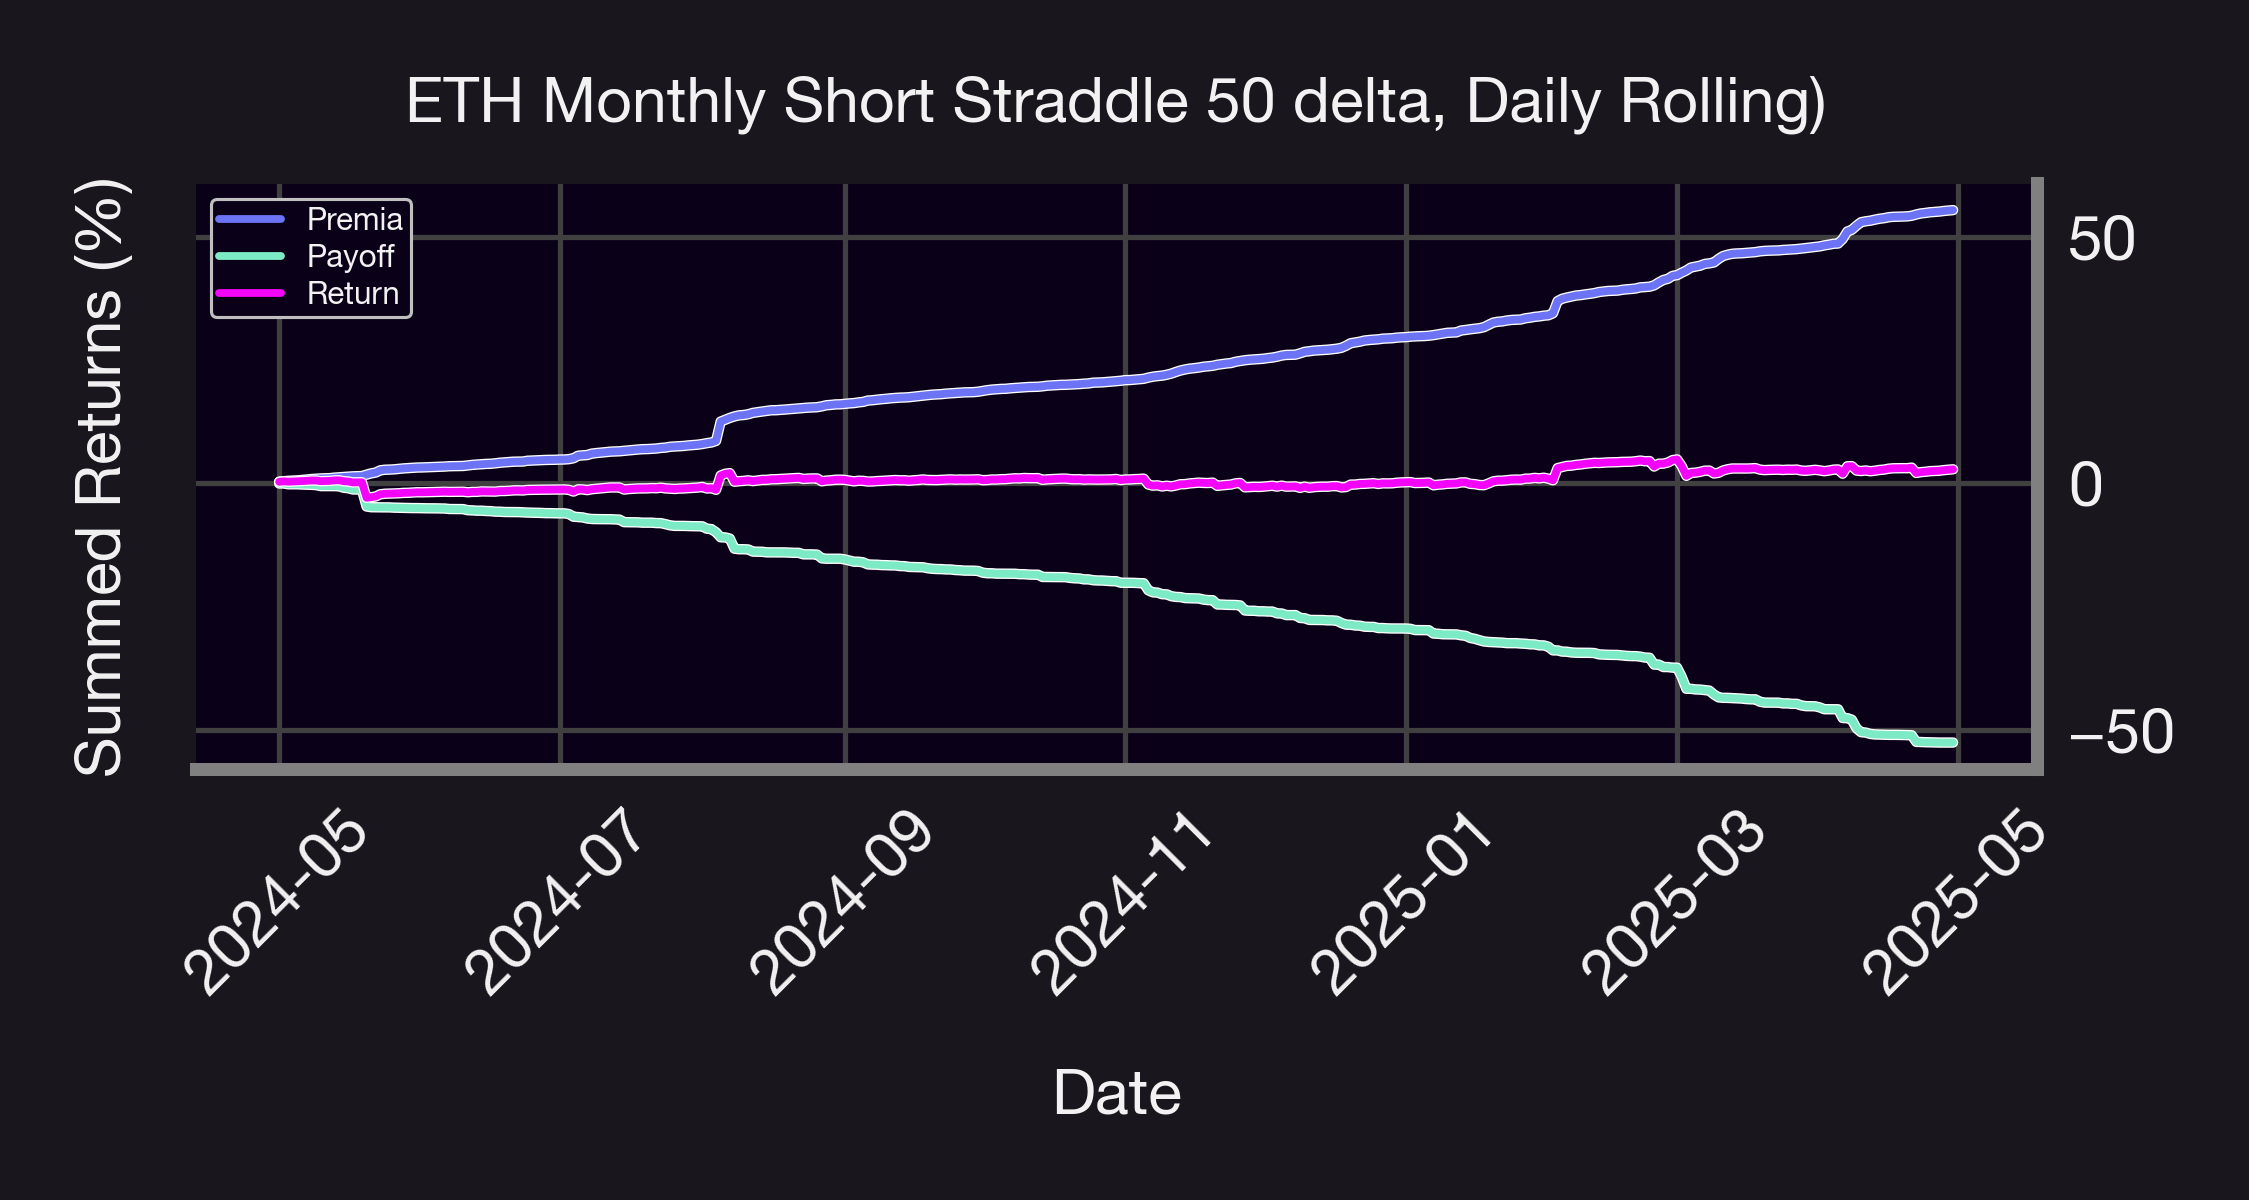

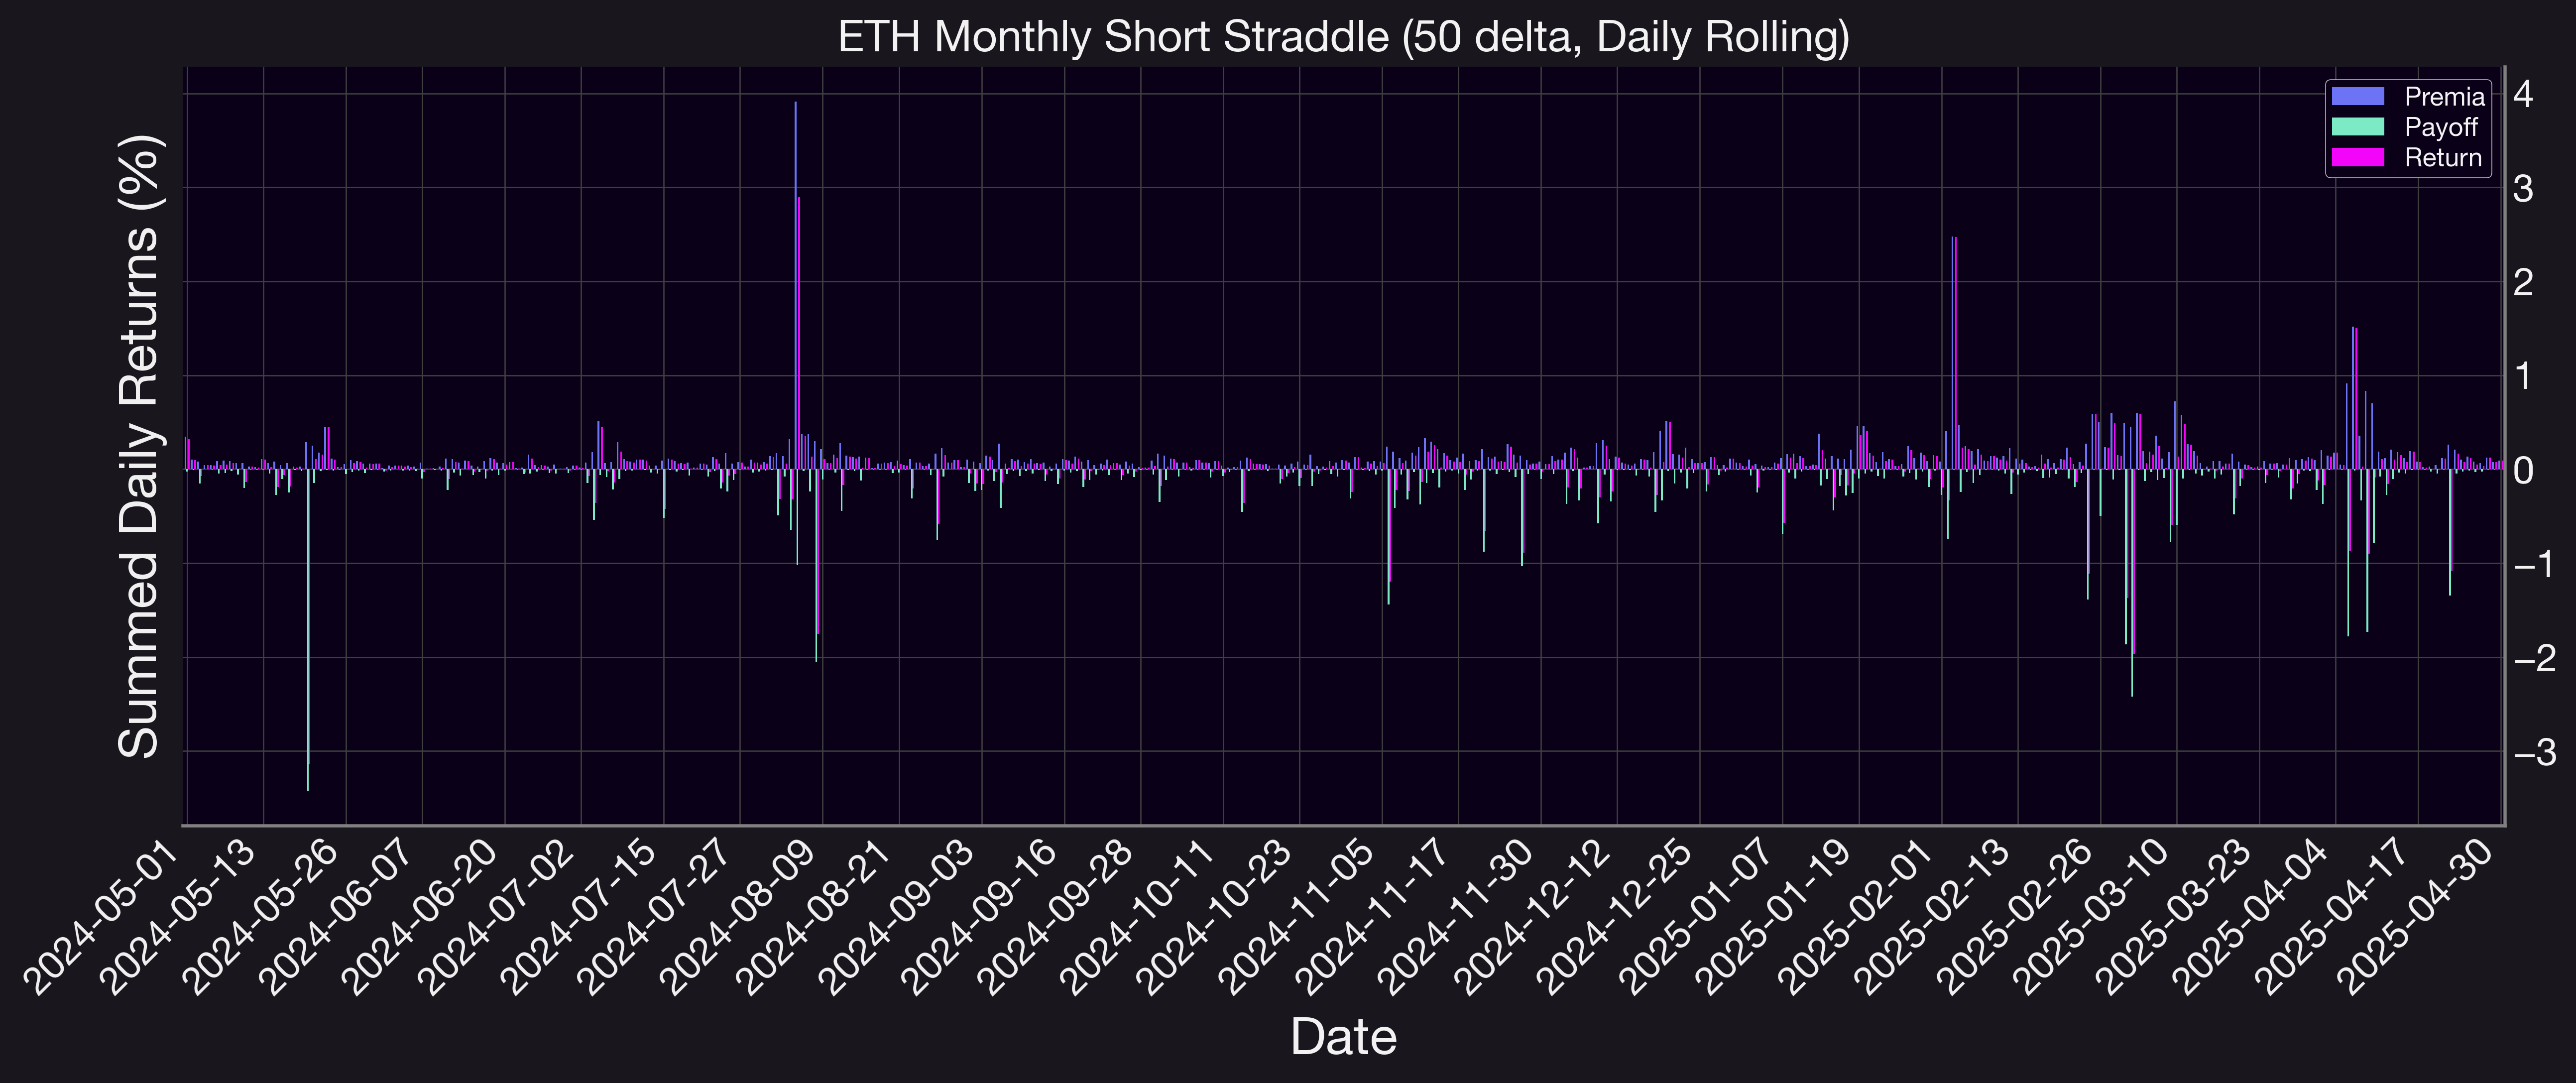

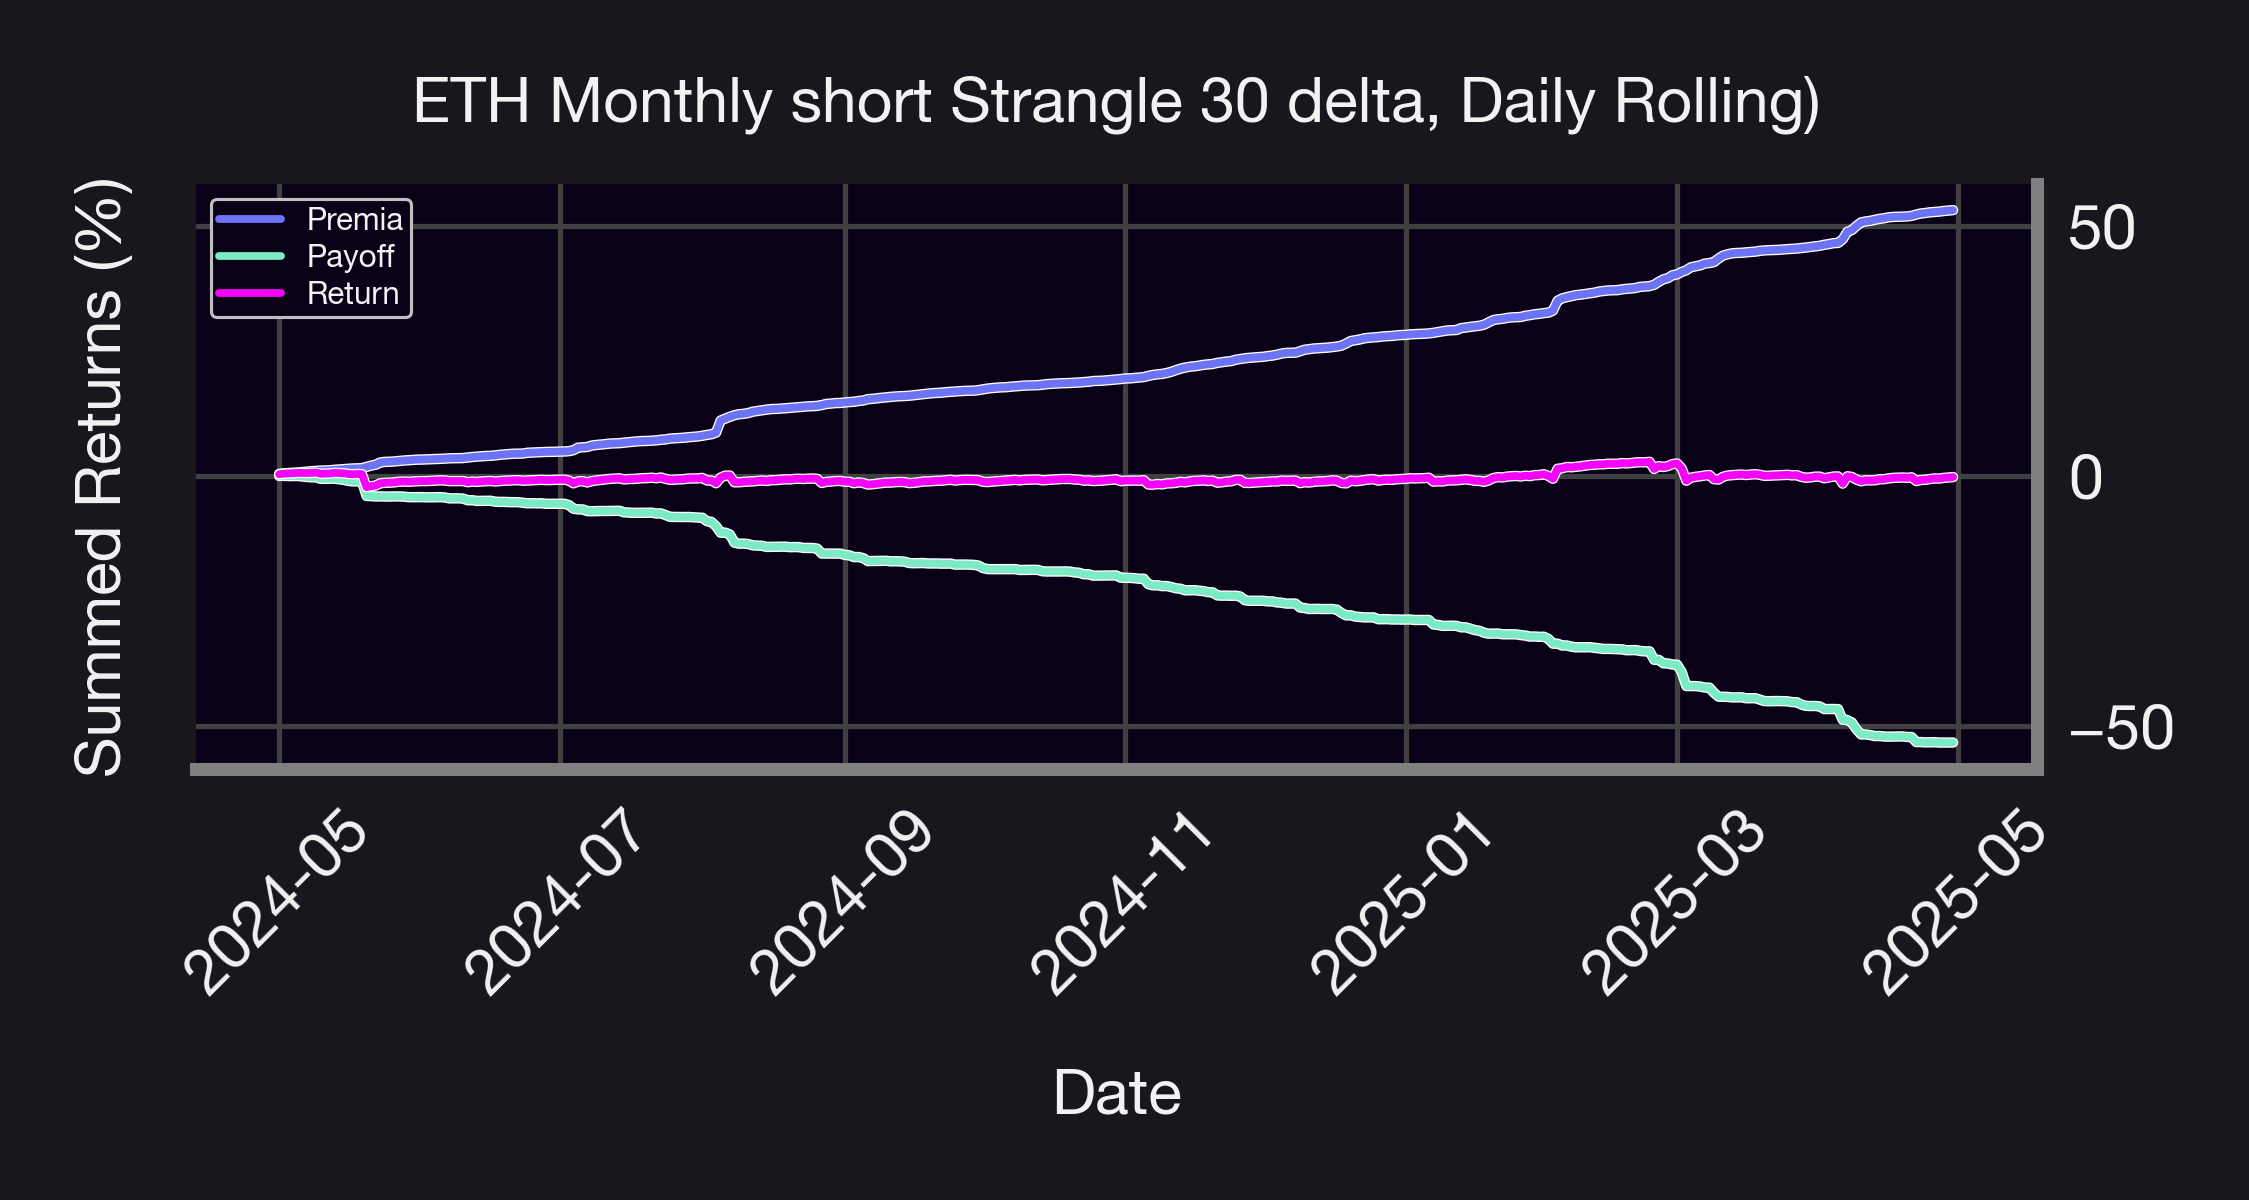

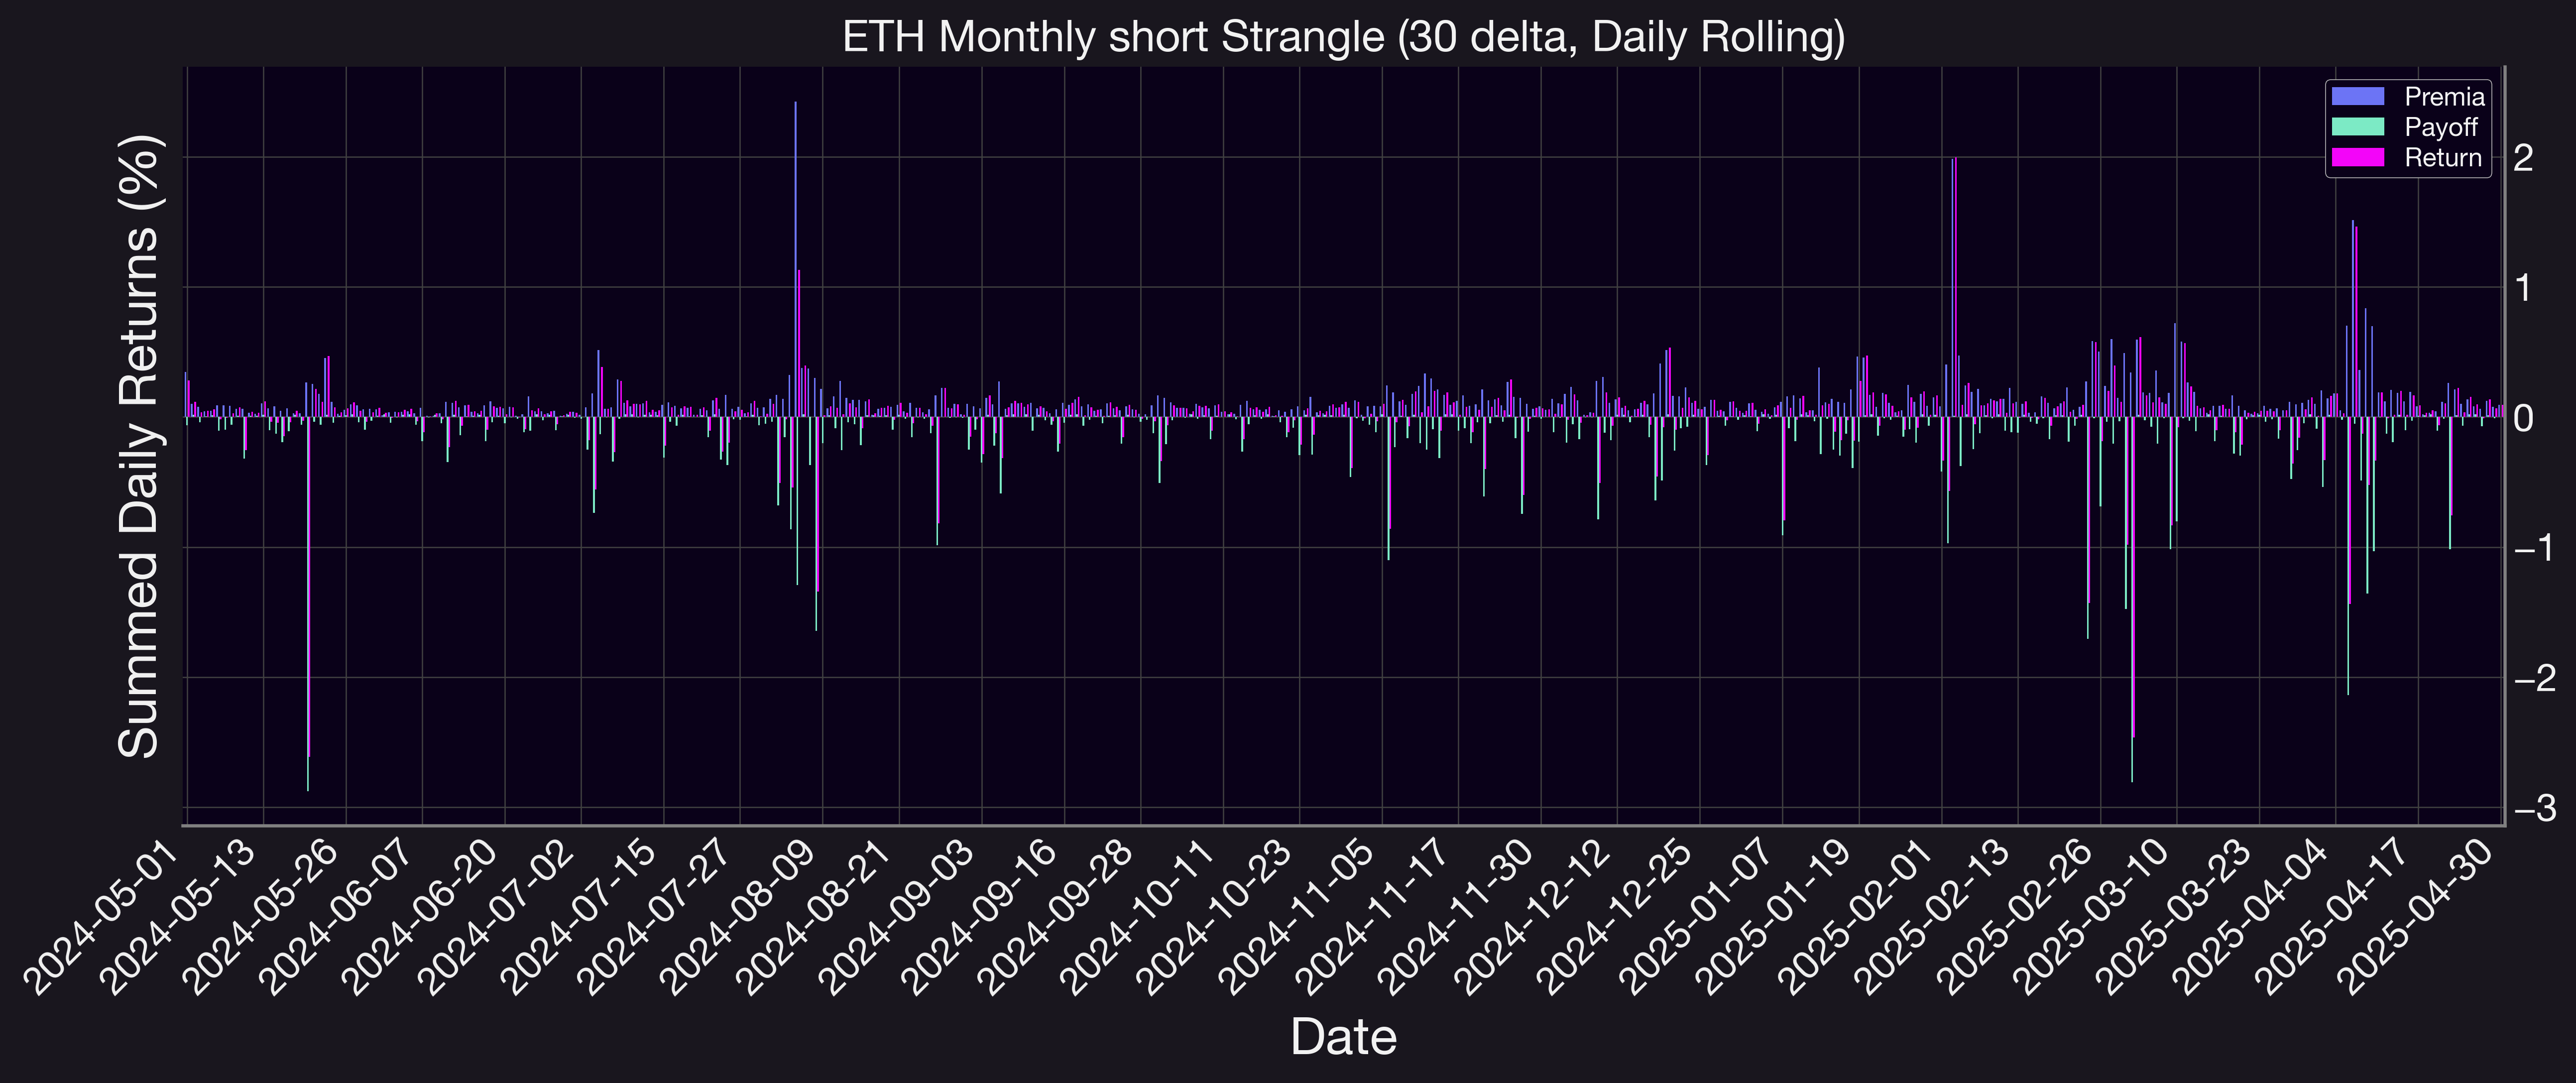

In [68]:
'''Summed Returns'''
rets = {}
for strat, period in strategies.items():
          # Extract the strategy name from the legs dictionary
     #legs_dict = strat.legs
     #strategy_key = list(legs_dict.keys())[0]  # Get the first key
     deltas = [leg[2] for leg in strat.legs]
     delta = int(abs(deltas[0])*100)
     print(deltas)
     # strategy_name = classify_strategy(strat.legs, strat.delta)
     strategy_name = classify_strategy(strat.legs, deltas)
 
     #strategy_name = strategy_key.replace('_', ' ').title()
     print(strategy_name)


     if 'a' in period or 'd' in period:
          rets['Premia'] = strat.daily_fees['fees_perc']
          rets['Payoff'] = strat.daily_pos['pnl_perc']
          # rets['Commissions'] = strat.daily_com['coms_perc']
          # rets['PLP_yield'] = strat.daily_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.daily_pos['pnl_perc'] \
                              + strat.daily_fees['fees_perc'] \
                              - strat.daily_com['coms_perc'] \
                              + strat.daily_PLP_yield['PLP_yield_perc']
          period_label = 'Daily'
          period_name = 'Dailies'

          
     if 'a' in period or 'w' in period:
          rets['Premia'] = strat.weekly_fees['fees_perc']
          rets['Payoff'] = strat.weekly_pos['pnl_perc']
          # rets['Commissions'] = strat.daily_com['coms_perc']
          # rets['PLP_yield'] = strat.weekly_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.weekly_pos['pnl_perc'] \
                              + strat.weekly_fees['fees_perc'] \
                              - strat.weekly_com['coms_perc'] \
                              + strat.weekly_PLP_yield['PLP_yield_perc']
          period_label = 'Weekly'
          period_name = 'Weeklies'
     if 'a' in period or 'm' in period:
          rets['Premia'] = strat.monthly_fees['fees_perc']
          rets['Payoff'] = strat.monthly_pos['pnl_perc']
          #rets['Commissions'] = strat.daily_com['coms_perc']
          #rets['PLP_yield'] = strat.monthly_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.monthly_pos['pnl_perc'] \
                               + strat.monthly_fees['fees_perc'] \
                               - strat.monthly_com['coms_perc'] \
                               + strat.monthly_PLP_yield['PLP_yield_perc']
          period_label = 'Monthly'
          period_name = 'Monthlies'

     # Plot rebalancing strategies
     plot_summed_rets(rets = rets,
          xlabel = 'Date',
          ylabel = 'Summed Returns (%)',
          title = f'ETH Monthly {strategy_name} {delta} delta, {period_label} Rolling)',
          dir = f"{strat.raw_dir}{strat_label(strat, period_label)}",
          label=False

     )
     
     # Plot
     df_rests = pd.DataFrame(rets)*100
     ax = df_rests.plot(kind='bar', width=0.8, figsize=(14, 6))  # save the axes object

     # Custom X-tick control
     num_ticks = 30  # Choose how many date labels to show
     x_values = df_rests.index  # datetime index
     tick_indices = np.linspace(0, len(x_values) - 1, num_ticks, dtype=int)
     tick_positions = tick_indices
     tick_labels = x_values[tick_indices] # Or '%b %Y' for shorter labels

     ax.set_xticks(tick_positions)
     ax.set_xticklabels(tick_labels, rotation=45, ha='right')

     # Formatting
     plt.xlabel('Date', fontsize=20)
     plt.xticks(fontsize=15)
     plt.yticks(fontsize=15)
     plt.ylabel(f'Summed {period_label} Returns (%)', fontsize=20) 
     #plt.title(f'ETH Monthly {strategy_name} ({int(abs(next(iter(strat.delta.values())) * 100))} delta, {period_label} Rolling) - {strat.chain} Net',fontsize=17)
     #plt.title(f'ETH Monthly {strategy_name} ({int(abs(next(iter(strat.delta.values())) * 100))} delta, {period_label} Rolling)',fontsize=17)

     plt.title(f'ETH Monthly {strategy_name} ({delta} delta, {period_label} Rolling)',fontsize=17)

     plt.legend(['Premia', 'Payoff', 'Return'],fontsize=10)

     # Compute cumulative sums
     cumulative = df_rests.cumsum()

     # Get the last accumulated value of each metric
     last_premia = cumulative['Premia'].iloc[-1]
     last_payoff = cumulative['Payoff'].iloc[-1]
     last_return = cumulative['Return'].iloc[-1]

     # Output
     print(f"Accumulated Premia: {last_premia:.2f}%")
     print(f"Accumulated Payoff: {last_payoff:.2f}%")
     print(f"Accumulated Return: {last_return:.2f}%")


     compute_stats(df_rests, period_label)

     # Compute win rate (percentage of positive return periods)
     positive_returns = rets['Return'][rets['Return'] > 0]
     win_rate = len(positive_returns) / len(rets['Return']) * 100

     print(f"✅ Win Rate for {strategy_name} ({period_label} Rolling): {win_rate:.2f}%")


In [56]:
  # --- Summary Statistics + Sharpe Ratio ---
sharpe_ratios = df_rests.mean() / df_rests.std()
summary = df_rests.describe().loc[['min', '25%', '50%', '75%', 'max']]
summary.loc['Sharpe Ratio'] = sharpe_ratios
print(f"\nSummary Statistics for {strategy_name} ({period_label}):\n")
print(summary)


Summary Statistics for Long Strangle (Monthly):

                Premia     Payoff     Return
min          -5.280844   0.008083  -5.204689
25%          -4.144548   0.154745  -2.584769
50%          -2.762226   1.219017  -1.253583
75%          -2.567265   4.925025   2.240893
max          -1.484102  14.107189  11.064507
Sharpe Ratio -2.883146   0.764026   0.081743


# ETH, Time to breach

In [5]:
def compute_breach_time(entry_time, upper, lower, eth_prices_df):
    entry_time = pd.to_datetime(entry_time)
    if entry_time.tzinfo is None:
        entry_time = entry_time.tz_localize('UTC')
    else:
        entry_time = entry_time.tz_convert('UTC')

    try:
        price_slice = eth_prices_df.loc[entry_time:]
    except KeyError:
        price_slice = eth_prices_df[eth_prices_df.index >= entry_time]

    for t in price_slice.index:
        price = eth_prices_df.loc[t, 'price']
        price = price.iloc[0] if isinstance(price, pd.Series) else price  # force scalar

        if (price > upper) or (price < lower):
            return (t - entry_time).total_seconds() / 3600

    return None


In [27]:
eth_prices = pd.read_csv('eth_prices_2year.csv')
eth_prices['timestamp'] = pd.to_datetime(eth_prices['timestamp'])  # Convert to datetime
eth_prices.set_index('timestamp', inplace=True)  # Set as index
eth_prices.sort_index(inplace=True)  # Optional: sort chronologically

In [28]:
eth_prices.index

DatetimeIndex(['2023-07-01 00:42:35+00:00', '2023-07-01 01:06:59+00:00',
               '2023-07-01 01:07:35+00:00', '2023-07-01 01:07:59+00:00',
               '2023-07-01 01:08:11+00:00', '2023-07-01 01:16:35+00:00',
               '2023-07-01 01:42:11+00:00', '2023-07-01 02:06:35+00:00',
               '2023-07-01 02:06:59+00:00', '2023-07-01 02:48:11+00:00',
               ...
               '2025-06-30 21:51:59+00:00', '2025-06-30 21:52:11+00:00',
               '2025-06-30 21:52:35+00:00', '2025-06-30 21:52:35+00:00',
               '2025-06-30 21:52:47+00:00', '2025-06-30 21:52:59+00:00',
               '2025-06-30 21:53:59+00:00', '2025-06-30 21:54:11+00:00',
               '2025-06-30 21:56:11+00:00', '2025-06-30 22:14:11+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp', length=268056, freq=None)

In [29]:
print(eth_prices.index.dtype)


datetime64[ns, UTC]


/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2892810958.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


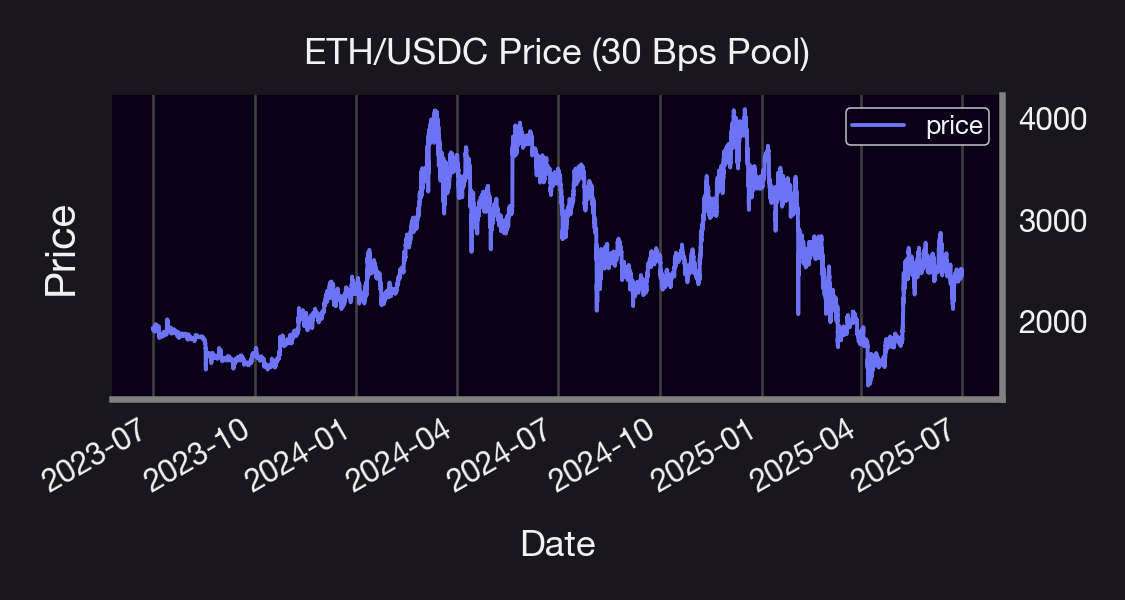

In [30]:
eth_prices.plot()
plt.title('ETH/USDC Price (30 Bps Pool)')
plt.xlabel('Date')
plt.ylabel('Price', fontsize=8)
plt.grid(axis='y')
plt.tight_layout()


/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/282938617.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  eth_monthly = eth_prices['price'].resample('M').last()
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/282938617.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


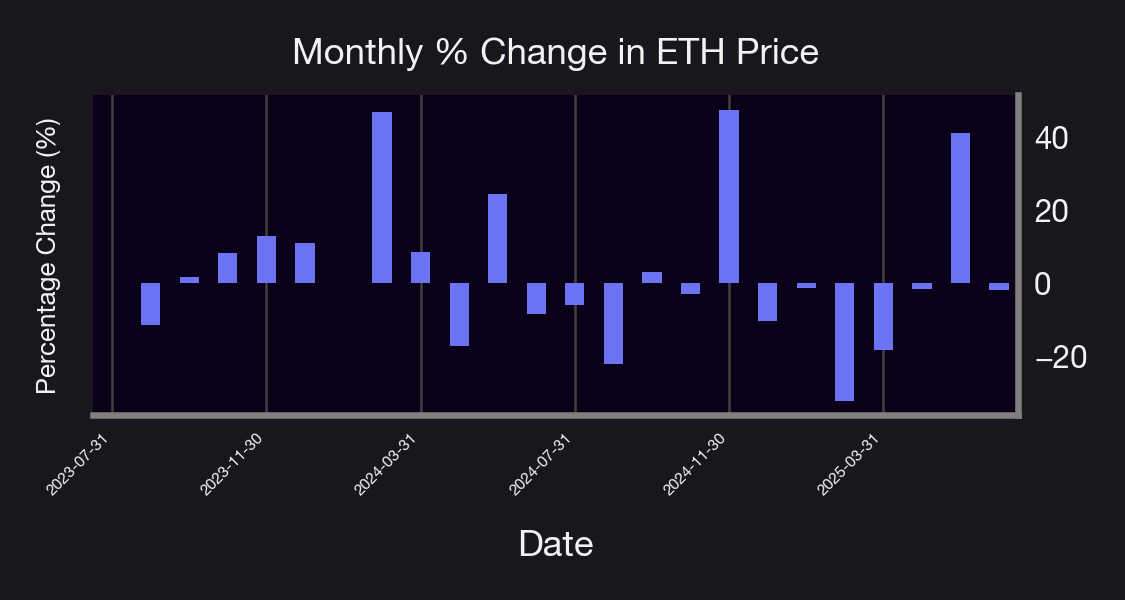

In [31]:

freq = 'm'
if freq == 'w':
    eth_monthly = eth_prices['price'].resample('W').last()
    frequency = 'Weekly'

elif freq == 'm':
    eth_monthly = eth_prices['price'].resample('M').last()
    frequency = 'Monthly'
else:
    eth_monthly = eth_prices['price'].resample('D').last()
    frequency = 'Daily'

# 2. Compute percent change
eth_monthly_pct = eth_monthly.pct_change() * 100

# 3. Plot
#ax = eth_monthly_pct.plot(kind='bar', color='steelblue', edgecolor='black')
ax = eth_monthly_pct.plot(kind='bar')

# Format x-axis to show 'YYYY-MM-DD' with fewer ticks
tick_locs = ax.get_xticks()
tick_labels = [ts.strftime('%Y-%m-%d') for ts in eth_monthly_pct.index]

# Show every 4th tick
N = 4
ax.set_xticks(tick_locs[::N])
ax.set_xticklabels(tick_labels[::N], rotation=45, ha='right', fontsize=3)

plt.title(f'{frequency} % Change in ETH Price')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)', fontsize=5)
plt.grid(axis='y')
plt.tight_layout()

# Delta Analysis

In [14]:
start = '2023-01-01'
end = '2025-01-01'

## Breach Rates, Win rates 

- For each rolling frequency, we backtest the strategy for each OTM delta from the list, we get the breach rate (how many times we live the range), the win rates, the statistical metrics and we plot everything.

In [58]:
all_results_dict = dict()

In [32]:
eth_prices

,price
timestamp,
2023-07-01 00:42:35+00:00,1937.636459
2023-07-01 01:06:59+00:00,1937.248990
2023-07-01 01:07:35+00:00,1935.506337
2023-07-01 01:07:59+00:00,1933.765252
2023-07-01 01:08:11+00:00,1933.378557
...,...
2025-06-30 21:52:59+00:00,2496.416344
2025-06-30 21:53:59+00:00,2494.669551
2025-06-30 21:54:11+00:00,2492.176253


In [21]:
from scipy.stats import skew


def compute_stats_updated(df, label, breach_flags=None):
    returns = df['Return']
    
    # Periods per year based on crypto (365d)
    freq_map = {
        'D Rolling': 365,
        'W Rolling': 52,
        'M Rolling': 12
    }
    periods_per_year = freq_map.get(label, 1)

    # Basic stats
    avg_return = returns.mean()
    std_return = returns.std()
    annualized_return = avg_return * periods_per_year
    sharpe_ratio = (avg_return / std_return) * np.sqrt(periods_per_year) if std_return > 0 else np.nan
    min_return = returns.min()
    max_return = returns.max()
    win_rate = (returns > 0).mean() * 100

    # Return skewness
    return_skewness = skew(returns)

    # Profit factor
    total_profit = returns[returns > 0].sum()
    total_loss = abs(returns[returns < 0].sum())
    profit_factor = total_profit / total_loss if total_loss != 0 else np.nan

    # Max drawdown
    cum_returns = (1 + returns / 100).cumprod()
    drawdown = cum_returns / cum_returns.cummax() - 1
    max_drawdown = drawdown.min() * 100  # as percentage

    # Conditional stats on breached trades
    if breach_flags is not None and breach_flags.any():
        breached_returns = returns[breach_flags]
        cond_sharpe = (breached_returns.mean() / breached_returns.std()) * np.sqrt(periods_per_year) if breached_returns.std() > 0 else np.nan
        avg_breach_severity = breached_returns.abs().mean()
        return_to_breach_ratio = avg_return / (breach_flags.mean() * 100 + 1e-6)
    else:
        cond_sharpe = np.nan
        avg_breach_severity = np.nan
        return_to_breach_ratio = np.nan

    return {
        'avg_return': avg_return,
        'annualized_return': annualized_return,
        'min_return': min_return,
        'max_return': max_return,
        'sharpe_ratio': sharpe_ratio,
        'win_rate': win_rate,
        'return_skewness': return_skewness,
        'profit_factor': profit_factor,
        'max_drawdown': max_drawdown,
        'conditional_sharpe_breaches': cond_sharpe,
        'avg_breach_severity': avg_breach_severity,
        'return_to_breach_ratio': return_to_breach_ratio,
        'label': label
    }


In [13]:
def compute_stats(df, label):
    avg_return = df.mean().values[0]
    min_return = df.min().values[0]
    max_return = df.max().values[0]
    sharpe_ratio = (df.mean() / df.std()).values[0]
    
    return {
        'avg_return': avg_return,
        'min_return': min_return,
        'max_return': max_return,
        'sharpe_ratio': sharpe_ratio,
        'label': label
    }


In [22]:
def get_results_from_strategy(strat,period):
     rets = {}
     if 'a' in period or 'd' in period:
          rets['Premia'] = strat.daily_fees['fees_perc']
          rets['Payoff'] = strat.daily_pos['pnl_perc']
          # rets['Commissions'] = strat.daily_com['coms_perc']
          # rets['PLP_yield'] = strat.daily_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.daily_pos['pnl_perc'] \
                              + strat.daily_fees['fees_perc'] \
                              - strat.daily_com['coms_perc'] \
                              + strat.daily_PLP_yield['PLP_yield_perc']
          
     if 'a' in period or 'w' in period:
          rets['Premia'] = strat.weekly_fees['fees_perc']
          rets['Payoff'] = strat.weekly_pos['pnl_perc']
          # rets['Commissions'] = strat.daily_com['coms_perc']
          # rets['PLP_yield'] = strat.weekly_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.weekly_pos['pnl_perc'] \
                         + strat.weekly_fees['fees_perc'] \
                         - strat.weekly_com['coms_perc'] \
                         + strat.weekly_PLP_yield['PLP_yield_perc']
     
     if 'a' in period or 'm' in period:
          rets['Premia'] = strat.monthly_fees['fees_perc']
          rets['Payoff'] = strat.monthly_pos['pnl_perc']
          #rets['Commissions'] = strat.daily_com['coms_perc']
          #rets['PLP_yield'] = strat.monthly_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.monthly_pos['pnl_perc'] \
                              + strat.monthly_fees['fees_perc'] \
                              - strat.monthly_com['coms_perc'] \
                              + strat.monthly_PLP_yield['PLP_yield_perc']
          
               
     return rets


In [23]:
def make_utc(ts):
    ts = pd.Timestamp(ts)
    return ts.tz_localize('UTC') if ts.tz is None else ts.tz_convert('UTC')


In [26]:
def backtest_strangles(deltas, period, period_label, eth_prices, local_dir, LP_Rebalance):
    results = []

    for delta_variable in deltas:
        strat_strangle = LP_Rebalance(
            token_0='WBTC',
            token_1='USDC',
            fee=30,
            local_dir=local_dir,
            start_t='2023-07-01',
            end_t='2025-07-01',
            range_perc=27,
            col_ratio=100,
            com_ratio=0,
            PLP_annual_yield=0,
            spread_mult=1,
            inverse_price=True,
            legs=[('SHORT_CALL', 0.5, -delta_variable), ('SHORT_PUT', 0.5, delta_variable)],
            chain='Ethereum'
        )

        strat_strangle.run_strat(period)
        rets = get_results_from_strategy(strat_strangle, period)
        df_rets = pd.DataFrame(rets) * 100

        # Setup
        breach_flags = []
        total_positions = 0
        breach_count = 0

        if period == 'd':
            position_df = strat_strangle.daily_pos
            range_df = strat_strangle.daily
        elif period == 'w':
            position_df = strat_strangle.weekly_pos
            range_df = strat_strangle.weekly
        elif period == 'm':
            position_df = strat_strangle.monthly_pos
            range_df = strat_strangle.monthly
        else:
            raise ValueError("Unsupported period.")

        for entry_time, _ in position_df.iterrows():
            entry_time = make_utc(entry_time)
            try:
                range_row = range_df.loc[str(entry_time.date())]
            except KeyError:
                breach_flags.append(False)
                continue

            lower = range_row['price_a_0'].iloc[0]
            upper = range_row['price_b_0'].iloc[0]
            price_path = eth_prices.loc[entry_time:]
            breached = ((price_path['price'] < lower) | (price_path['price'] > upper)).any()

            total_positions += 1
            breach_count += int(breached)
            breach_flags.append(breached)

        breach_rate = (breach_count / total_positions) * 100 if total_positions > 0 else 0
        breach_flags_series = pd.Series(breach_flags, index=df_rets.index)


        stats = compute_stats_updated(df_rets[['Return']], period_label, breach_flags_series)
        stats.update({
            'delta': delta_variable,
            'breach_rate': breach_rate
        })

        results.append(stats)

    return pd.DataFrame(results)

In [33]:
deltas = np.round(np.arange(0.05, 0.5, 0.05), 2)  # From 0.05 to 0.45
period = "d"  # for weekly rebalancing
period_label = "D Rolling"
results = backtest_strangles(deltas, period, period_label, eth_prices, local_dir, LP_Rebalance)

Loading Data...
Downloading: 100%|██████████|
Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 136194/136194 [00:00<00:00, 243970.78it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 136194/136194 [00:06<00:00, 19612.24it/s]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:504: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_close = df['price'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:505: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sqrtPrice_close = df['sqrtPrice'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:167: DeprecationWarning: DataFrameGroupBy.ap

Loading Data...
Downloading: 100%|██████████|
Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 136194/136194 [00:00<00:00, 191648.44it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 136194/136194 [00:06<00:00, 20567.16it/s]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:504: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_close = df['price'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:505: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sqrtPrice_close = df['sqrtPrice'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:167: DeprecationWarning: DataFrameGroupBy.ap

Loading Data...
Downloading: 100%|██████████|
Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 136194/136194 [00:00<00:00, 244209.21it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 136194/136194 [00:06<00:00, 20436.43it/s]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:504: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_close = df['price'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:505: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sqrtPrice_close = df['sqrtPrice'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_61756/2756151253.py:167: DeprecationWarning: DataFrameGroupBy.ap

Loading Data...
Downloading: 100%|██████████|
Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 136194/136194 [00:00<00:00, 210429.25it/s]
0it [00:00, ?it/s]
Step 2:  47%|████▋     | 63874/136194 [00:02<00:02, 24534.47it/s]

In [187]:
#all_results_dict_2year = dict()
all_results_dict_2year_btc = dict()

In [188]:
# Convert your results list to a DataFrame
#results_df = pd.DataFrame(results)
results_df_btc = pd.DataFrame(results)

In [189]:
period

'd'

In [190]:
#all_results_dict_2year[period]=results_df
all_results_dict_2year_btc[period]=results_df_btc

In [191]:
#all_results_dict_2year['w']

all_results_dict_2year_btc['d']

,avg_return,annualized_return,min_return,max_return,sharpe_ratio,win_rate,return_skewness,profit_factor,max_drawdown,conditional_sharpe_breaches,avg_breach_severity,return_to_breach_ratio,label,delta,breach_rate
0,0.004096,1.495135,-0.930477,1.517416,0.632021,69.083447,1.161686,1.136077,-2.594569,0.632021,0.064301,0.000041,D Rolling,0.05,100.0
1,0.005397,1.969742,-1.146707,1.559445,0.692722,68.262654,0.009650,1.150918,-3.293229,0.692722,0.076913,0.000054,D Rolling,0.10,100.0
2,0.007183,2.621879,-1.307520,2.065359,0.805414,67.031464,0.960412,1.184962,-3.425935,0.805414,0.084856,0.000072,D Rolling,0.15,100.0
3,0.008401,3.066381,-1.401173,2.729056,0.853301,65.937073,2.842900,1.206127,-3.561690,0.853301,0.089914,0.000084,D Rolling,0.20,100.0
4,0.009192,3.354931,-1.432882,3.098537,0.892924,65.526676,4.149736,1.223019,-3.503187,0.892924,0.091620,0.000092,D Rolling,0.25,100.0
5,0.009800,3.577078,-1.409866,3.277534,0.942206,66.210670,5.050451,1.243636,-3.329354,0.942206,0.090250,0.000098,D Rolling,0.30,100.0
6,0.010499,3.832255,-1.369831,3.319386,1.026839,67.305062,5.729068,1.277730,-2.976598,1.026839,0.086108,0.000105,D Rolling,0.35,100.0
7,0.011395,4.159249,-1.305045,3.286991,1.156914,68.946648,6.448665,1.331271,-2.436956,1.156914,0.080192,0.000114,D Rolling,0.40,100.0
8,0.012581,4.592239,-1.215503,3.227219,1.339981,71.135431,7.331644,1.415458,-1.729383,1.339981,0.073148,0.000126,D Rolling,0.45,100.0


In [194]:
all_results_dict_2year_eth = all_results_dict_2year

In [198]:
import pickle
with open("all_results_dict_2year_eth.pkl", "wb") as f:  # binary write
    pickle.dump(all_results_dict_2year_eth, f)

# ----- load (after restart) -----
with open("all_results_dict_2year.pkl", "rb") as f:
    my_dict = pickle.load(f)


In [199]:
with open("all_results_dict_2year_eth.pkl", "rb") as f:
    my_dict = pickle.load(f)

In [200]:
my_dict

{'d':    avg_return  annualized_return  min_return  max_return  sharpe_ratio  \
 0   -0.002245          -0.819579   -2.146396    1.492343     -0.213302   
 1   -0.003188          -1.163688   -2.478810    1.534106     -0.258826   
 2   -0.002263          -0.825832   -2.757690    1.598253     -0.168812   
 3   -0.001098          -0.400655   -2.990549    1.656030     -0.078017   
 4    0.000345           0.126027   -3.170011    1.836547      0.023821   
 5    0.001113           0.406125   -3.333152    2.003404      0.075368   
 6    0.002356           0.859776   -3.463354    2.270679      0.156173   
 7    0.002998           1.094429   -3.555313    2.404156      0.193994   
 8    0.002877           1.050190   -3.729113    2.706376      0.180222   
 
     win_rate  return_skewness  profit_factor  max_drawdown  \
 0  68.946648        -3.098846       0.955283     -4.500292   
 1  70.177839        -3.620255       0.946492     -5.687624   
 2  68.536252        -4.031109       0.964020     -6.2

In [31]:
my_dict['d']

,delta,win_rate,avg_return,min_return,max_return,sharpe_ratio,breach_rate
0,0.05,67.759563,-0.001581,-0.729428,0.299872,-0.015492,99.453552
1,0.10,68.852459,-0.001193,-0.860522,0.350969,-0.009764,98.633880
2,0.15,67.759563,0.001283,-0.880716,0.392027,0.009936,98.087432
3,0.20,68.852459,0.003110,-0.885896,0.429932,0.023821,95.355191
4,0.25,68.852459,0.004251,-0.872573,0.450400,0.032710,93.715847
5,0.30,69.125683,0.004568,-0.886147,0.452742,0.035554,93.715847
6,0.35,68.579235,0.004347,-0.928932,0.459344,0.034567,93.989071
7,0.40,70.218579,0.003534,-1.000827,0.470191,0.028579,94.535519
8,0.45,70.218579,0.002218,-1.101832,0.485284,0.017849,93.715847


/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_30458/2637424192.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


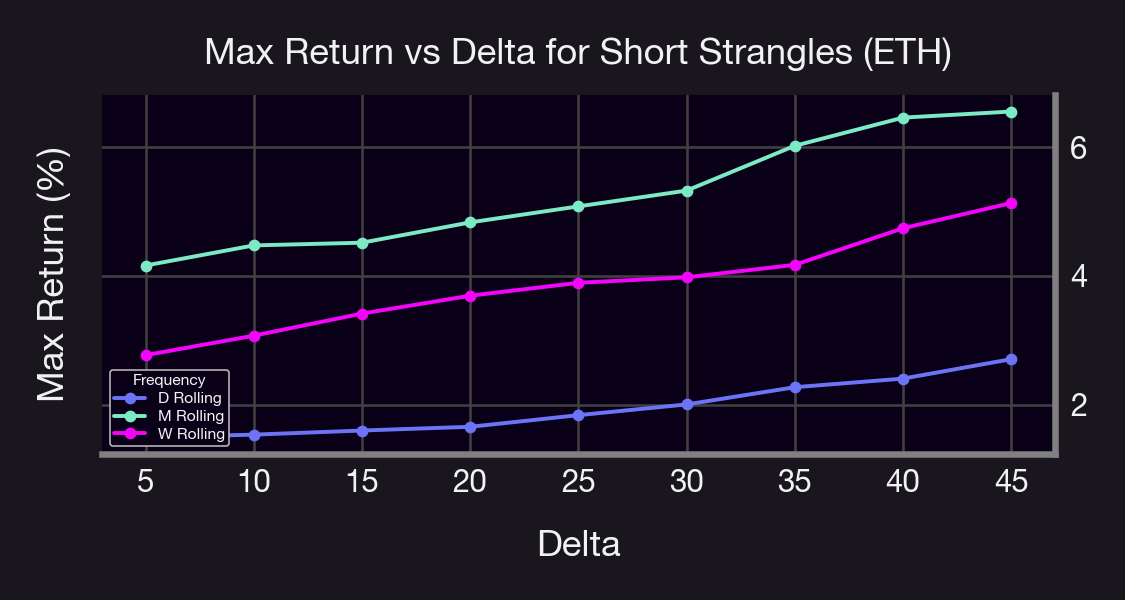

In [211]:

for freq, df in all_results_dict_2year_eth.items():
    plt.plot(df['delta']*100, df['max_return'], marker='o', label=f'{freq.upper()} Rolling')

plt.title('Max Return vs Delta for Short Strangles (ETH)')
plt.xlabel('Delta')
plt.ylabel('Max Return (%)')
plt.legend(loc='lower left', title='Frequency', fontsize=3,title_fontsize=3 )
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_30458/3192375257.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


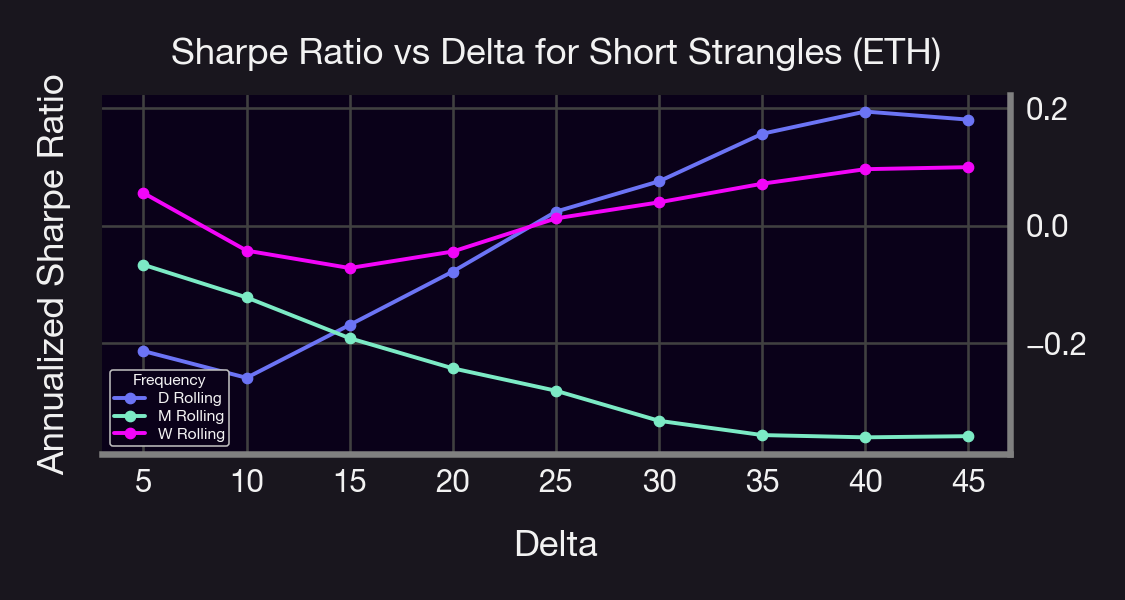

In [206]:
#plt.figure(figsize=(10, 6))

for freq, df in all_results_dict_2year_eth.items():
    plt.plot(df['delta']*100, df['sharpe_ratio'], marker='o', label=f'{freq.upper()} Rolling')

plt.title('Sharpe Ratio vs Delta for Short Strangles (ETH)')
plt.xlabel('Delta')
plt.ylabel('Annualized Sharpe Ratio')
plt.legend(loc='lower left', title='Frequency', fontsize=3,title_fontsize=3 )
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_30458/3912495707.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


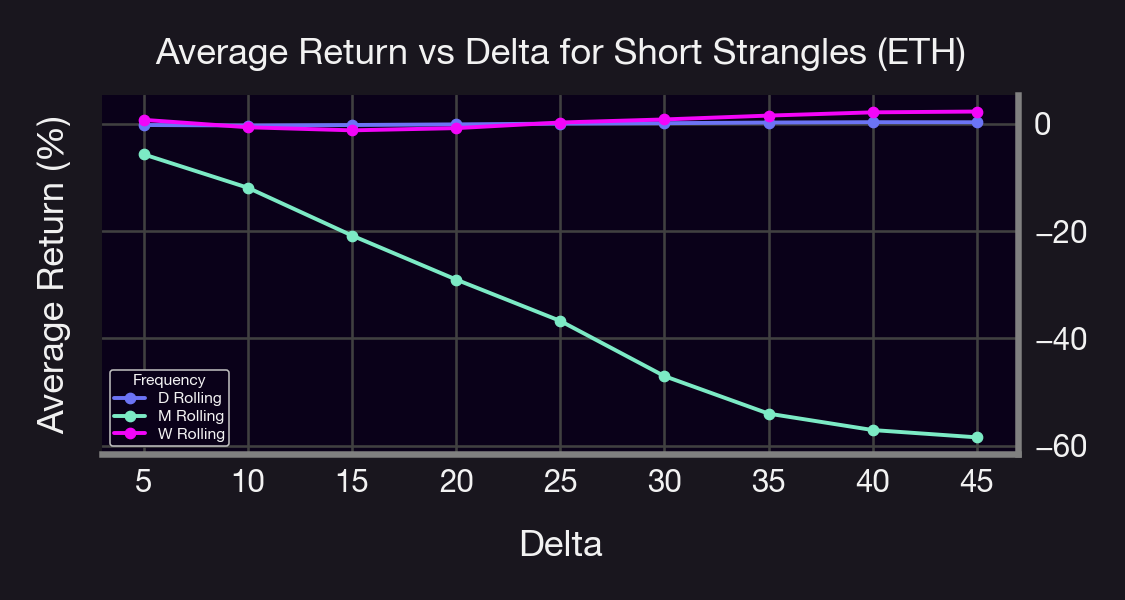

In [207]:
for freq, df in all_results_dict_2year_eth.items():
    plt.plot(df['delta']*100, df['avg_return']*100, marker='o', label=f'{freq.upper()} Rolling')
    
plt.title('Average Return vs Delta for Short Strangles (ETH)')
plt.xlabel('Delta')
plt.ylabel('Average Return (%)')
plt.legend(loc='lower left', title='Frequency', fontsize=3,title_fontsize=3 )

plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_30458/3965021687.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


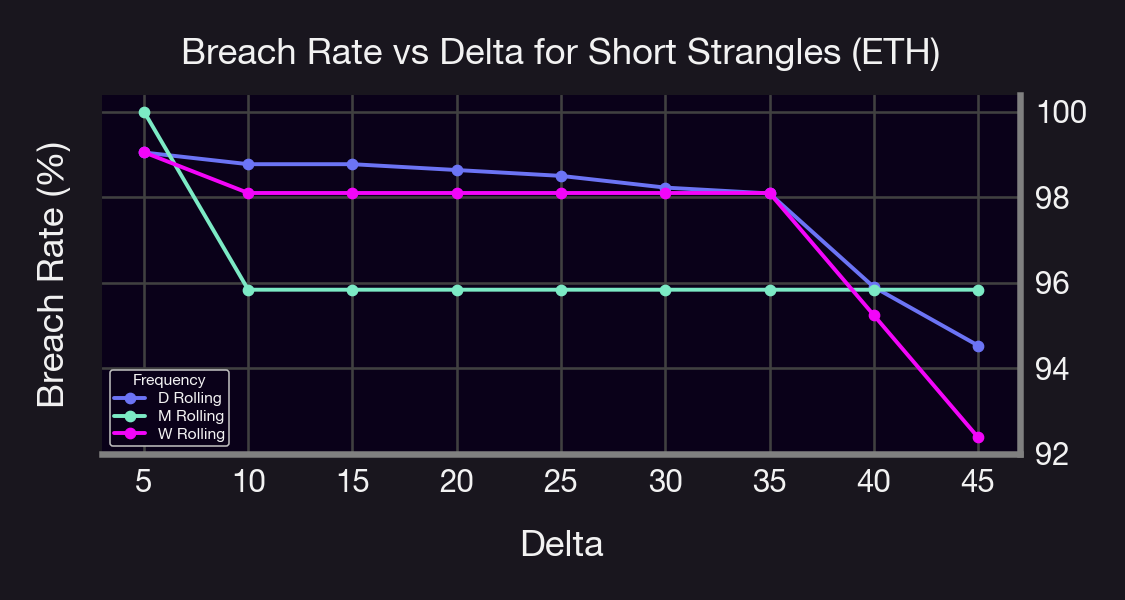

In [208]:
for freq, df in all_results_dict_2year_eth.items():
    plt.plot(df['delta']*100, df['breach_rate'], marker='o', label=f'{freq.upper()} Rolling')

plt.title('Breach Rate vs Delta for Short Strangles (ETH)')
plt.xlabel('Delta')
plt.ylabel('Breach Rate (%)')
plt.legend(loc='lower left', title='Frequency', fontsize=3,title_fontsize=3 )
plt.grid(True)
plt.tight_layout()
plt.show()


In [205]:
df

,avg_return,annualized_return,min_return,max_return,sharpe_ratio,win_rate,return_skewness,profit_factor,max_drawdown,conditional_sharpe_breaches,avg_breach_severity,return_to_breach_ratio,label,delta,breach_rate
0,0.007329,0.381097,-5.565681,2.768537,0.055439,63.207547,-2.263858,1.027398,-6.380355,0.096035,0.546226,0.000075,W Rolling,0.05,99.047619
1,-0.006470,-0.336431,-6.283649,3.070702,-0.042497,62.264151,-2.250219,0.980038,-8.610126,0.040704,0.646361,-0.000067,W Rolling,0.10,98.095238
2,-0.012196,-0.634172,-6.984365,3.413985,-0.072133,64.150943,-2.320437,0.966039,-10.374777,0.013126,0.710690,-0.000126,W Rolling,0.15,98.095238
3,-0.008079,-0.420119,-7.652946,3.691440,-0.044024,66.037736,-2.427578,0.978800,-11.505964,0.033733,0.760417,-0.000083,W Rolling,0.20,98.095238
4,0.002398,0.124714,-8.288538,3.891795,0.012284,66.981132,-2.573880,1.006157,-11.869816,0.085602,0.788749,0.000025,W Rolling,0.25,98.095238
5,0.008127,0.422582,-8.954163,3.977123,0.039634,67.924528,-2.758851,1.020570,-12.018267,0.107111,0.806595,0.000084,W Rolling,0.30,98.095238
6,0.015287,0.794921,-9.677074,4.170635,0.071250,66.981132,-2.895774,1.038403,-11.690551,0.133503,0.820678,0.000157,W Rolling,0.35,98.095238
7,0.021348,1.110108,-10.304388,4.739033,0.095986,66.981132,-3.008977,1.053616,-11.271830,0.682985,0.730232,0.000226,W Rolling,0.40,95.238095
8,0.022840,1.187674,-10.917798,5.130004,0.099423,66.981132,-3.157888,1.057209,-10.945784,0.562182,0.719888,0.000250,W Rolling,0.45,92.380952


/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_30458/1798279115.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


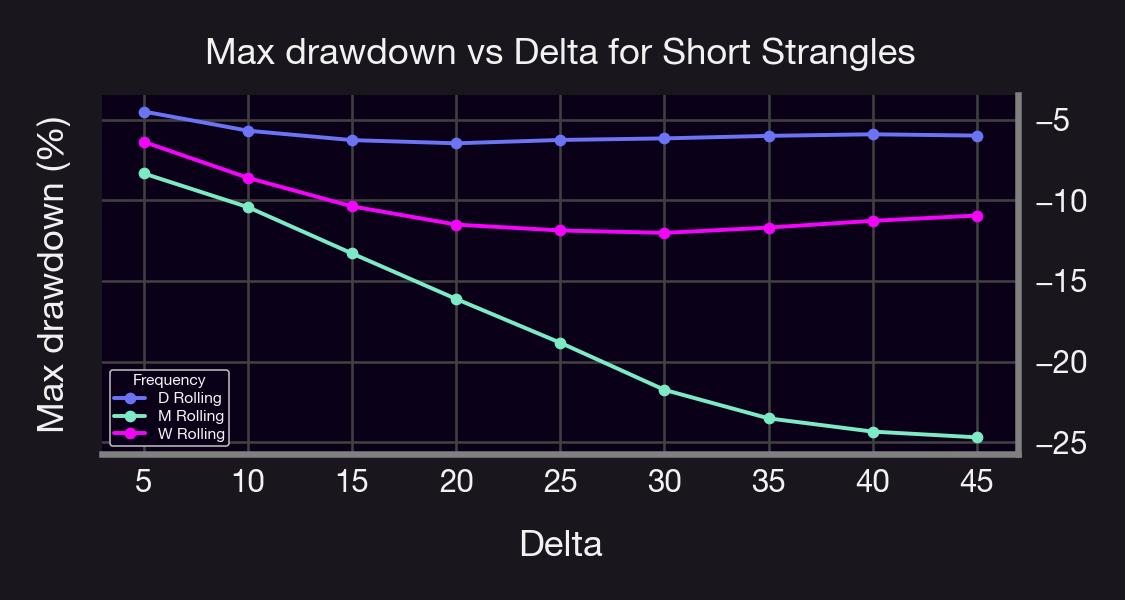

In [204]:
for freq, df in all_results_dict_2year_eth.items():
    plt.plot(df['delta']*100, df['max_drawdown'], marker='o', label=f'{freq.upper()} Rolling')

plt.title('Max drawdown vs Delta for Short Strangles')
plt.xlabel('Delta')
plt.ylabel('Max drawdown (%)')
plt.legend(loc='lower left', title='Frequency', fontsize=3,title_fontsize=3 )
plt.grid(True)
plt.tight_layout()
plt.show()


In [106]:
all_results_dict

{'w':    avg_return  annualized_return  min_return  max_return  sharpe_ratio  \
 0   -0.008577          -0.446024   -5.565563    2.765680     -0.056275   
 1   -0.030279          -1.574512   -6.283532    3.067777     -0.172767   
 2   -0.046867          -2.437058   -6.984116    3.411627     -0.240714   
 3   -0.045803          -2.381731   -7.652691    3.688855     -0.216554   
 4   -0.033449          -1.739373   -8.288283    3.889210     -0.148500   
 5   -0.025921          -1.347906   -8.953902    3.974537     -0.109496   
 6   -0.016163          -0.840467   -9.676813    4.172660     -0.065195   
 7   -0.007674          -0.399072  -10.304140    4.741058     -0.029844   
 8   -0.003831          -0.199194  -10.917550    5.130318     -0.014417   
 
     win_rate  return_skewness  profit_factor  max_drawdown  \
 0  60.759494        -1.949651       0.974853     -6.385643   
 1  60.759494        -1.934304       0.926431     -8.614932   
 2  59.493671        -1.976327       0.898195    -10.3

/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_30458/447493932.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


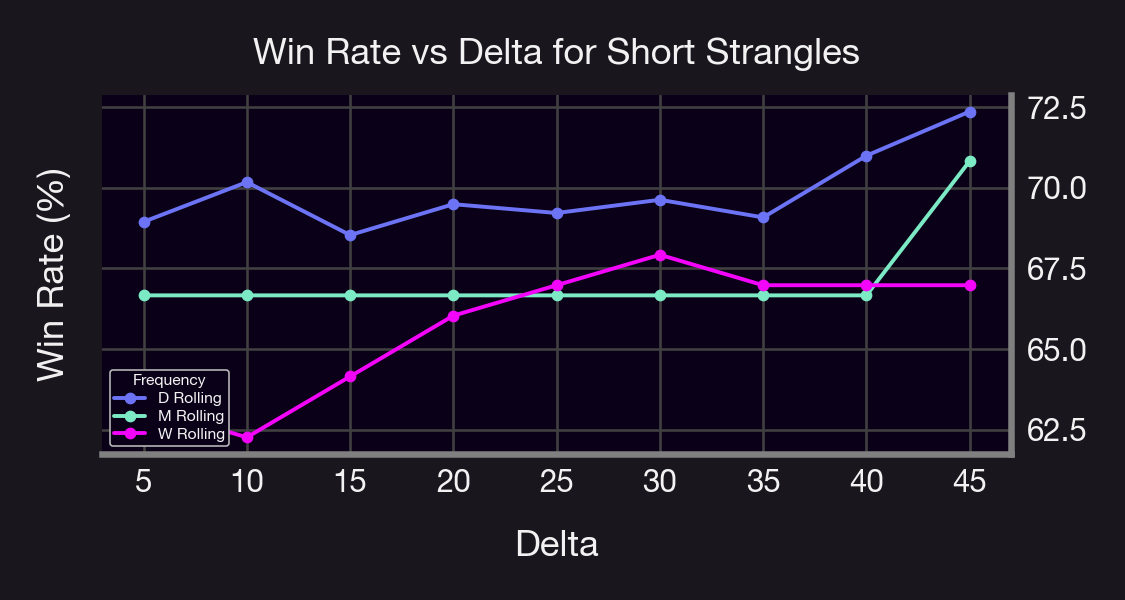

In [180]:

for freq, df in all_results_dict_2year.items():
    plt.plot(df['delta']*100, df['win_rate'], marker='o', label=f'{freq.upper()} Rolling')

plt.title('Win Rate vs Delta for Short Strangles')
plt.xlabel('Delta')
plt.ylabel('Win Rate (%)')
plt.legend(loc='lower left', title='Frequency', fontsize=3,title_fontsize=3 )
plt.grid(True)
plt.tight_layout()
plt.show()
